In [1]:
# importing python utility libraries
import os, sys, random, io, urllib
from datetime import datetime

# importing pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# importing python plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
from IPython.display import Image, display

In [4]:
USE_CUDA = False

In [7]:
# init deterministic seed
seed_value = 1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

In [9]:
# load the synthetic ERP dataset
ori_dataset = pd.read_csv('./data/fraud_dataset_v2.csv')


We augmented the dataset and renamed the attributes to appear more similar to a real-world dataset that one usually observes in SAP-ERP systems as part of SAP's Finance and Cost controlling (FICO) module. 

The dataset contains a subset of in total 7 categorical and 2 numerical attributes available in the FICO BKPF (containing the posted journal entry headers) and BSEG (containing the posted journal entry segments) tables. Please, find below a list of the individual attributes as well as a brief description of their respective semantics:

>- `BELNR`: the accounting document number,
>- `BUKRS`: the company code,
>- `BSCHL`: the posting key,
>- `HKONT`: the posted general ledger account,
>- `PRCTR`: the posted profit center,
>- `WAERS`: the currency key,
>- `KTOSL`: the general ledger account key,
>- `DMBTR`: the amount in local currency,
>- `WRBTR`: the amount in document currency.

In [13]:
# remove the "ground-truth" label information for the following steps of the lab
label = ori_dataset.pop('label')

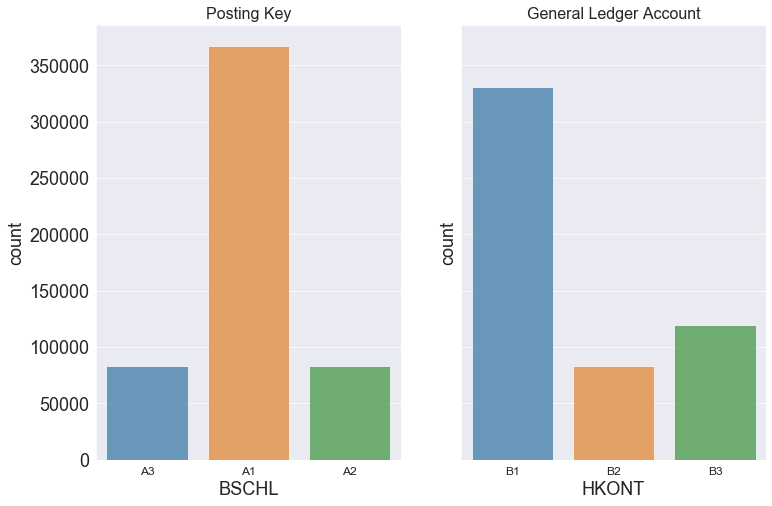

In [43]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1,2, sharey='row')
fig.set_figwidth(12)
fig.set_figheight(8)

plt.rc('font', size=18) 
# plot the distribution of the posting key attribute
g = sns.countplot(x=ori_dataset.loc[label=='regular', 'BSCHL'], ax=ax[0], alpha=0.7)
g.set_xticklabels(g.get_xticklabels(), rotation=0, size=12)
g.set_title('Posting Key', size=16)

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=ori_dataset.loc[label=='regular', 'HKONT'], ax=ax[1], alpha=0.7)
g.set_xticklabels(g.get_xticklabels(), rotation=0, size=12)
g.set_title('General Ledger Account', size=16);

In [16]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'BUKRS', 'WAERS']

# encode categorical attributes into a binary one-hot encoded representation 
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

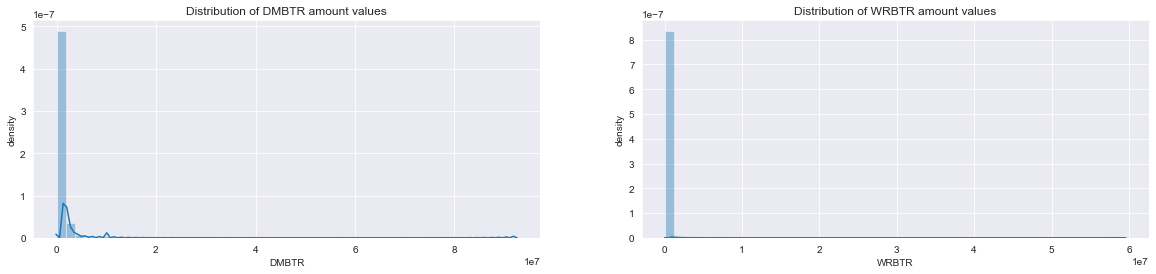

In [18]:
# init the plots
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of DMBTR amount values')

# set axis-labels 
ax[0].set_xlabel('DMBTR')
ax[0].set_ylabel('density')

# plot distribution of the document amount attribute
g = sns.distplot(ori_dataset['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of WRBTR amount values')

# set axis-labels
ax[1].set_xlabel('WRBTR')
ax[1].set_ylabel('density');

In [19]:
# select "DMBTR" vs. "WRBTR" attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-4
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

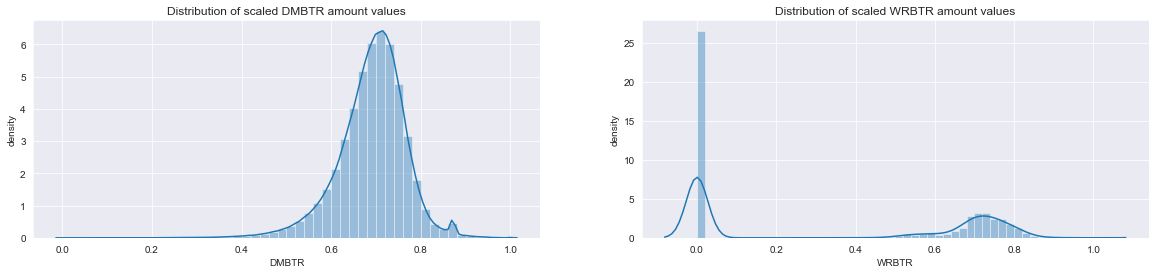

In [20]:
# init the plots
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset_numeric_attr['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of scaled DMBTR amount values')

# set axis-labels 
ax[0].set_xlabel('DMBTR')
ax[0].set_ylabel('density')

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset_numeric_attr['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of scaled WRBTR amount values')

# set axis-labels
ax[1].set_xlabel('WRBTR')
ax[1].set_ylabel('density');

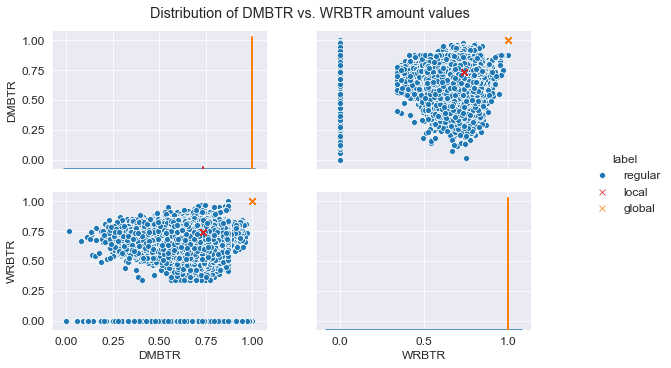

In [45]:
# append 'label' attribute 
numeric_attr_vis = ori_dataset_numeric_attr.copy()
numeric_attr_vis['label'] = label
plt.rc('font', size=12) 
# plot the log-scaled and min-max normalized numeric attributes
g = sns.pairplot(data=numeric_attr_vis, vars=numeric_attr_names, hue='label', palette={'regular': 'C0', 'local': 'C3', 'global': 'C1'}, markers=['o', 'x', 'x'])

# set figure title
g.fig.suptitle('Distribution of DMBTR vs. WRBTR amount values', y=1.02)

# set figure size
g.fig.set_size_inches(10, 5)

In [46]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)

In [47]:
# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(533009, 618)

In [48]:
# define encoder class
class Encoder(nn.Module):

    # define class constructor
    def __init__(self, input_size, hidden_size):

        # call super class constructor
        super(Encoder, self).__init__()

        # specify first layer - in 618, out 256
        self.map_L1 = nn.Linear(input_size, hidden_size[0], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 256, out 64
        self.map_L2 = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 64, out 16
        self.map_L3 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fourth layer - in 16, out 4
        self.map_L4 = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_R4 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        '''
        # specify fifth layer - in 4, out 2
        self.map_L5 = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_L5.weight)
        nn.init.constant_(self.map_L5.bias, 0.0)
        self.map_R5 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)
        '''
        
        # define forward layer for mu and var
        self.map_mu = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_mu.weight)
        nn.init.constant_(self.map_mu.weight, 0.0)
        self.map_var = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_var.weight)
        nn.init.constant_(self.map_var.weight, 0.0)        
        
        
    # define reparameterize method
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_R4(self.map_L4(x))
        #x = self.map_R5(self.map_L5(x))
        
        # Calculate mu, logvar and pass to reparameterize method
        mu, logvar = self.map_mu(x), self.map_var(x)
        z = self.reparameterize(mu, logvar)
        
        # return result
        return z, mu, logvar

In [49]:
# init training network classes / architectures
encoder_train = Encoder(input_size=ori_subset_transformed.shape[1], hidden_size=[256, 64, 16, 4, 2])

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    encoder_train = encoder_train.cuda()

In [50]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] variational-encoder-generator architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 20200407-20:34:10] variational-encoder-generator architecture:

Encoder(
  (map_L1): Linear(in_features=618, out_features=256, bias=True)
  (map_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L2): Linear(in_features=256, out_features=64, bias=True)
  (map_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L3): Linear(in_features=64, out_features=16, bias=True)
  (map_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L4): Linear(in_features=16, out_features=4, bias=True)
  (map_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_mu): Linear(in_features=4, out_features=2, bias=True)
  (map_var): Linear(in_features=4, out_features=2, bias=True)
)



In [51]:
# define decoder class
class Decoder(nn.Module):

    # define class constructor
    def __init__(self, output_size, hidden_size):

        # call super class constructor
        super(Decoder, self).__init__()

        # specify first layer - in 2, out 4
        self.map_L1 = nn.Linear(hidden_size[0], hidden_size[1], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 4, out 16
        self.map_L2 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 16, out 64
        self.map_L3 = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fourth layer - in 64, out 256
        self.map_L4 = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify fifth layer - in 256, out 618
        self.map_L5 = nn.Linear(hidden_size[4], output_size, bias=True)
        nn.init.xavier_uniform_(self.map_L5.weight)
        nn.init.constant_(self.map_L5.bias, 0.0)
        self.map_S5 = torch.nn.Sigmoid()

    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_R4(self.map_L4(x))
        x = self.map_S5(self.map_L5(x))

        # return result
        return x

In [52]:
# init training network classes / architectures
decoder_train = Decoder(output_size=ori_subset_transformed.shape[1], hidden_size=[2, 4, 16, 64, 256])

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    decoder_train = decoder_train.cuda()
    
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20200407-20:34:15] decoder architecture:

Decoder(
  (map_L1): Linear(in_features=2, out_features=4, bias=True)
  (map_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L2): Linear(in_features=4, out_features=16, bias=True)
  (map_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L3): Linear(in_features=16, out_features=64, bias=True)
  (map_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L4): Linear(in_features=64, out_features=256, bias=True)
  (map_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L5): Linear(in_features=256, out_features=618, bias=True)
  (map_S5): Sigmoid()
)



In [53]:
# define discriminator class
class Discriminator(nn.Module):

    # define class constructor
    def __init__(self, input_size, hidden_size, output_size):

        # call super class constructor
        super(Discriminator, self).__init__()

        # specify first layer - in 2, out 256
        self.map_L1 = nn.Linear(input_size, hidden_size[0], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 256, out 16
        self.map_L2 = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 16, out 4
        self.map_L3 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify fourth layer - in 4, out 2
        self.map_L4 = nn.Linear(hidden_size[2], output_size, bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_S4 = torch.nn.Sigmoid()

    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_S4(self.map_L4(x))

        # return result
        return x

In [54]:
# init training network classes / architectures
discriminator_train = Discriminator(input_size=2, hidden_size=[256, 16, 4, 2], output_size=1)

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    discriminator_train = discriminator_train.cuda()
    
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] discriminator architecture:\n\n{}\n'.format(now, discriminator_train))

[LOG 20200407-20:34:25] discriminator architecture:

Discriminator(
  (map_L1): Linear(in_features=2, out_features=256, bias=True)
  (map_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L2): Linear(in_features=256, out_features=16, bias=True)
  (map_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L3): Linear(in_features=16, out_features=4, bias=True)
  (map_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L4): Linear(in_features=4, out_features=1, bias=True)
  (map_S4): Sigmoid()
)



In [55]:
# define the optimization criterion / loss function
reconstruction_criterion_categorical = nn.BCELoss(reduction='mean')
reconstruction_criterion_numeric = nn.MSELoss(reduction='mean')

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    reconstruction_criterion_categorical = reconstruction_criterion_categorical.cuda()
    reconstruction_criterion_numeric = reconstruction_criterion_numeric.cuda()

In [56]:
# define encoder and decoded learning rate
learning_rate_enc = 1e-3
learning_rate_dec = 1e-3

# define encoder and decoder optimization strategy
encoder_optimizer = optim.Adam(encoder_train.parameters(), lr=learning_rate_enc)
decoder_optimizer = optim.Adam(decoder_train.parameters(), lr=learning_rate_dec)

In [57]:
# init the discriminator losses
discriminator_criterion = nn.BCELoss()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    discriminator_criterion = discriminator_criterion.cuda()

In [58]:
# define generator and discriminator learning rate
learning_rate_dis_z = 1e-5

# define generator and discriminator optimization strategy
discriminator_optimizer = optim.Adam(discriminator_train.parameters(), lr=learning_rate_dis_z)

In [59]:
# define the number of gaussians
tau = 5 

# define radius of each gaussian
radius = 0.8

# define the sigma of each gaussian
sigma = 0.01

# define the dimensionality of each gaussian
dim = 2

# determine x and y coordinates of the target mixture of gaussians
x_centroid = (radius * np.sin(np.linspace(0, 2 * np.pi, tau, endpoint=False)) + 1) / 2
y_centroid = (radius * np.cos(np.linspace(0, 2 * np.pi, tau, endpoint=False)) + 1) / 2

# determine each gaussians mean (centroid) and standard deviation
mu_gauss = np.vstack([x_centroid, y_centroid]).T

# determine the number of samples to be created per gaussian
samples_per_gaussian = 100000

# iterate over the number of distinct gaussians
for i, mu in enumerate(mu_gauss):

    # case: first gaussian
    if i == 0:

        # randomly sample from gaussion distribution 
        z_continous_samples_all = np.random.normal(mu, sigma, size=(samples_per_gaussian, dim))

    # case: non-first gaussian
    else:

        # randomly sample from gaussian distribution
        z_continous_samples = np.random.normal(mu, sigma, size=(samples_per_gaussian, dim))

        # collect and stack new samples
        z_continous_samples_all = np.vstack([z_continous_samples_all, z_continous_samples])

Let's visually inspect the generated prior distribution $p(z)$:

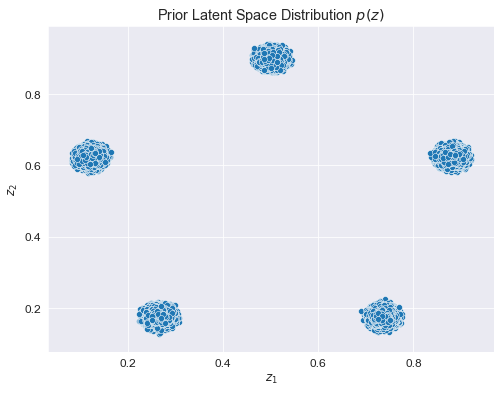

In [60]:
# init the plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# plot reconstruction error scatter plot
ax.scatter(z_continous_samples_all[:, 0], z_continous_samples_all[:, 1], c='C0', marker="o", edgecolors='w', linewidth=0.5) 
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

# add plot title
ax.set_title('Prior Latent Space Distribution $p(z)$');

In [61]:
# specify training parameters
num_epochs = 5000
mini_batch_size = 1024

In [62]:
# convert pre-processed data to pytorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

# convert to pytorch tensor - none cuda enabled
dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0)
# note: we set num_workers to zero to retrieve deterministic results

# determine if CUDA is available at compute node
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    dataloader = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=True)

In [63]:
# init collection of training losses
epoch_reconstruction_losses = []
#epoch_vae_losses = []
epoch_discriminator_losses = []
epoch_generator_losses = []

In [64]:
mini_batch_verbose_step = 1000

In [ ]:
# initialize training adversarial autoencoder model
for epoch in range(num_epochs):

    # init mini batch counter
    mini_batch_count = 0
    
    # init epoch training losses
    batch_reconstruction_losses = 0.0
    batch_vae_losses = 0.0
    batch_discriminator_losses = 0.0
    batch_generator_losses = 0.0

    # determine if GPU training is enabled
    if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):

        # set all networks / models in GPU mode
        encoder_train.cuda()
        decoder_train.cuda()
        discriminator_train.cuda()

    # set networks in training mode (apply dropout when needed)
    encoder_train.train()
    decoder_train.train()
    discriminator_train.train()
    
    # start timer
    start_time = datetime.now()

    # iterate over epoch mini batches
    for mini_batch_data in dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # determine if GPU training is enabled
        if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
          
            # convert mini batch to torch variable
            mini_batch_torch = torch.cuda.FloatTensor(mini_batch_data)

        else:
          
             # convert mini batch to torch variable
             mini_batch_torch = torch.FloatTensor(mini_batch_data)
        
        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

        # =================== reconstruction phase =====================
        
        # run autoencoder encoding - decoding
        z_sample, mu, logvar = encoder_train(mini_batch_torch)
        mini_batch_reconstruction = decoder_train(z_sample)

        # split input date to numerical and categorical part
        batch_cat = mini_batch_torch[:, :ori_dataset_categ_transformed.shape[1]]
        batch_num = mini_batch_torch[:, ori_dataset_categ_transformed.shape[1]:]
        
        # split reconstruction to numerical and categorical part
        rec_batch_cat = mini_batch_reconstruction[:, :ori_dataset_categ_transformed.shape[1]]
        rec_batch_num = mini_batch_reconstruction[:, ori_dataset_categ_transformed.shape[1]:]

        # backward pass + gradients update
        rec_error_cat = reconstruction_criterion_categorical(input=rec_batch_cat, target=batch_cat)  # one-hot attr error
        rec_error_num = reconstruction_criterion_numeric(input=rec_batch_num, target=batch_num)  # numeric attr error

        # combine both reconstruction errors
        # calculate vae loss
        reconstruction_loss = rec_error_cat + rec_error_num
        
        # run backward pass - determine gradients
        reconstruction_loss.backward()
        
        # collect batch reconstruction loss
        batch_reconstruction_losses += reconstruction_loss.item()
        
        # update network parameter - decoder and encoder
        decoder_optimizer.step()
        encoder_optimizer.step()

        # =================== regularization phase =====================
        # =================== discriminator training ===================

        # set discriminator in evaluation mode
        discriminator_train.eval()

        # generate target latent space data
        z_target_batch = z_continous_samples_all[random.sample(range(0, z_continous_samples_all.shape[0]), mini_batch_size),:]

        # convert to torch tensor
        z_target_batch = torch.FloatTensor(z_target_batch)

        if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
            z_target_batch = z_target_batch.cuda()

        # determine mini batch sample generated by the encoder -> fake gaussian sample
        z_fake_gauss, _, _ = encoder_train(mini_batch_torch)

        # determine discriminator classification of both samples
        d_real_gauss = discriminator_train(z_target_batch) # real sampled gaussian 
        d_fake_gauss = discriminator_train(z_fake_gauss) # fake created gaussian

        # determine discriminator classification target variables
        d_real_gauss_target = torch.FloatTensor(torch.ones(d_real_gauss.shape)) # real -> 1
        d_fake_gauss_target = torch.FloatTensor(torch.zeros(d_fake_gauss.shape)) # fake -> 0

        # determine if GPU training is enabled
        if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):

            # push tensors to CUDA
            d_real_gauss_target = d_real_gauss_target.cuda()
            d_fake_gauss_target = d_fake_gauss_target.cuda()

        # determine individual discrimination losses
        discriminator_loss_real = discriminator_criterion(target=d_real_gauss_target, input=d_real_gauss) # real loss
        discriminator_loss_fake = discriminator_criterion(target=d_fake_gauss_target, input=d_fake_gauss) # fake loss
        
        # add real loss and fake loss
        discriminator_loss = discriminator_loss_fake + discriminator_loss_real

        # run backward through the discriminator network
        discriminator_loss.backward()
        
        # collect discriminator loss
        batch_discriminator_losses += discriminator_loss.item()

        # update network the discriminator network parameters
        discriminator_optimizer.step()

        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

        # =================== regularization phase =====================
        # =================== generator training =======================

        # set encoder / generator in training mode
        encoder_train.train()
        
        # reset the encoder / generator networks gradients
        encoder_train.zero_grad()

        # determine fake gaussian sample generated by the encoder / generator
        z_fake_gauss, _, _ = encoder_train(mini_batch_torch)

        # determine discriminator classification of fake gaussian sample
        d_fake_gauss = discriminator_train(z_fake_gauss)

        # determine discriminator classification target variables
        d_fake_gauss_target = torch.FloatTensor(torch.ones(d_fake_gauss.shape)) # fake -> 1

        # determine if GPU training is enabled
        if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):

            # push tensors to CUDA
            d_fake_gauss_target = d_fake_gauss_target.cuda()

        # determine discrimination loss of fake gaussian sample
        generator_loss = discriminator_criterion(target=d_fake_gauss_target, input=d_fake_gauss)
        
        # collect generator loss
        batch_generator_losses += generator_loss.item()

        # run backward pass - determine gradients
        generator_loss.backward()

        # update network paramaters - encoder / generatorc
        encoder_optimizer.step()

        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

    # collect epoch training losses - reconstruction loss
    epoch_reconstruction_loss = batch_reconstruction_losses / mini_batch_count
    epoch_reconstruction_losses.extend([epoch_reconstruction_loss])
    
    # collect epoch training losses - discriminator loss
    epoch_discriminator_loss = batch_discriminator_losses / mini_batch_count
    epoch_discriminator_losses.extend([epoch_discriminator_loss])
    
    # collect epoch training losses - generator loss
    epoch_generator_loss = batch_generator_losses / mini_batch_count
    epoch_generator_losses.extend([epoch_generator_loss])
    
    # print epoch reconstruction loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG TRAIN {}] epoch: {:04}/{:04}, reconstruction loss: {:.4f}'.format(now, epoch + 1, num_epochs, epoch_reconstruction_loss))
    print('[LOG TRAIN {}] epoch: {:04}/{:04}, discriminator loss: {:.4f}'.format(now, epoch + 1, num_epochs, epoch_discriminator_loss))
    print('[LOG TRAIN {}] epoch: {:04}/{:04}, generator loss: {:.4f}'.format(now, epoch + 1, num_epochs, epoch_generator_loss))
    
    # =================== save model snapshots to disk ============================
    
    # save trained encoder model file to disk
    now = datetime.utcnow().strftime("%Y%m%d-%H_%M_%S")
    encoder_model_name = "{}_ep_{}_encoder_model.pth".format(now, (epoch+1))
    torch.save(encoder_train.state_dict(), os.path.join("./models", encoder_model_name))

    # save trained decoder model file to disk
    decoder_model_name = "{}_ep_{}_decoder_model.pth".format(now, (epoch+1))
    torch.save(decoder_train.state_dict(), os.path.join("./models", decoder_model_name))
    
    # save trained discriminator model file to disk
    decoder_model_name = "{}_ep_{}_discriminator_model.pth".format(now, (epoch+1))
    torch.save(discriminator_train.state_dict(), os.path.join("./models", decoder_model_name))

[LOG TRAIN 20200404-19:03:11] epoch: 0001/5000, reconstruction loss: 0.7813
[LOG TRAIN 20200404-19:03:11] epoch: 0001/5000, discriminator loss: 1.3943
[LOG TRAIN 20200404-19:03:11] epoch: 0001/5000, generator loss: 0.7082
[LOG TRAIN 20200404-19:03:15] epoch: 0002/5000, reconstruction loss: 0.7373
[LOG TRAIN 20200404-19:03:15] epoch: 0002/5000, discriminator loss: 1.3937
[LOG TRAIN 20200404-19:03:15] epoch: 0002/5000, generator loss: 0.7083
[LOG TRAIN 20200404-19:03:19] epoch: 0003/5000, reconstruction loss: 0.6562
[LOG TRAIN 20200404-19:03:19] epoch: 0003/5000, discriminator loss: 1.3956
[LOG TRAIN 20200404-19:03:19] epoch: 0003/5000, generator loss: 0.7059
[LOG TRAIN 20200404-19:03:23] epoch: 0004/5000, reconstruction loss: 0.4748
[LOG TRAIN 20200404-19:03:23] epoch: 0004/5000, discriminator loss: 1.3982
[LOG TRAIN 20200404-19:03:23] epoch: 0004/5000, generator loss: 0.7031
[LOG TRAIN 20200404-19:03:27] epoch: 0005/5000, reconstruction loss: 0.2489
[LOG TRAIN 20200404-19:03:27] epoch:

[LOG TRAIN 20200404-19:05:31] epoch: 0038/5000, reconstruction loss: 0.0626
[LOG TRAIN 20200404-19:05:31] epoch: 0038/5000, discriminator loss: 1.3739
[LOG TRAIN 20200404-19:05:31] epoch: 0038/5000, generator loss: 0.7142
[LOG TRAIN 20200404-19:05:35] epoch: 0039/5000, reconstruction loss: 0.0593
[LOG TRAIN 20200404-19:05:35] epoch: 0039/5000, discriminator loss: 1.3736
[LOG TRAIN 20200404-19:05:35] epoch: 0039/5000, generator loss: 0.7142
[LOG TRAIN 20200404-19:05:38] epoch: 0040/5000, reconstruction loss: 0.0562
[LOG TRAIN 20200404-19:05:38] epoch: 0040/5000, discriminator loss: 1.3738
[LOG TRAIN 20200404-19:05:38] epoch: 0040/5000, generator loss: 0.7138
[LOG TRAIN 20200404-19:05:42] epoch: 0041/5000, reconstruction loss: 0.0531
[LOG TRAIN 20200404-19:05:42] epoch: 0041/5000, discriminator loss: 1.3744
[LOG TRAIN 20200404-19:05:42] epoch: 0041/5000, generator loss: 0.7129
[LOG TRAIN 20200404-19:05:46] epoch: 0042/5000, reconstruction loss: 0.0499
[LOG TRAIN 20200404-19:05:46] epoch:

[LOG TRAIN 20200404-19:07:51] epoch: 0075/5000, reconstruction loss: 0.0334
[LOG TRAIN 20200404-19:07:51] epoch: 0075/5000, discriminator loss: 1.3887
[LOG TRAIN 20200404-19:07:51] epoch: 0075/5000, generator loss: 0.6929
[LOG TRAIN 20200404-19:07:54] epoch: 0076/5000, reconstruction loss: 0.0330
[LOG TRAIN 20200404-19:07:54] epoch: 0076/5000, discriminator loss: 1.3885
[LOG TRAIN 20200404-19:07:54] epoch: 0076/5000, generator loss: 0.6930
[LOG TRAIN 20200404-19:07:58] epoch: 0077/5000, reconstruction loss: 0.0328
[LOG TRAIN 20200404-19:07:58] epoch: 0077/5000, discriminator loss: 1.3884
[LOG TRAIN 20200404-19:07:58] epoch: 0077/5000, generator loss: 0.6931
[LOG TRAIN 20200404-19:08:02] epoch: 0078/5000, reconstruction loss: 0.0328
[LOG TRAIN 20200404-19:08:02] epoch: 0078/5000, discriminator loss: 1.3884
[LOG TRAIN 20200404-19:08:02] epoch: 0078/5000, generator loss: 0.6930
[LOG TRAIN 20200404-19:08:06] epoch: 0079/5000, reconstruction loss: 0.0328
[LOG TRAIN 20200404-19:08:06] epoch:

[LOG TRAIN 20200404-19:10:11] epoch: 0112/5000, reconstruction loss: 0.0320
[LOG TRAIN 20200404-19:10:11] epoch: 0112/5000, discriminator loss: 1.3870
[LOG TRAIN 20200404-19:10:11] epoch: 0112/5000, generator loss: 0.6915
[LOG TRAIN 20200404-19:10:15] epoch: 0113/5000, reconstruction loss: 0.0320
[LOG TRAIN 20200404-19:10:15] epoch: 0113/5000, discriminator loss: 1.3870
[LOG TRAIN 20200404-19:10:15] epoch: 0113/5000, generator loss: 0.6915
[LOG TRAIN 20200404-19:10:18] epoch: 0114/5000, reconstruction loss: 0.0320
[LOG TRAIN 20200404-19:10:18] epoch: 0114/5000, discriminator loss: 1.3870
[LOG TRAIN 20200404-19:10:18] epoch: 0114/5000, generator loss: 0.6914
[LOG TRAIN 20200404-19:10:22] epoch: 0115/5000, reconstruction loss: 0.0320
[LOG TRAIN 20200404-19:10:22] epoch: 0115/5000, discriminator loss: 1.3870
[LOG TRAIN 20200404-19:10:22] epoch: 0115/5000, generator loss: 0.6914
[LOG TRAIN 20200404-19:10:26] epoch: 0116/5000, reconstruction loss: 0.0320
[LOG TRAIN 20200404-19:10:26] epoch:

[LOG TRAIN 20200404-19:12:31] epoch: 0149/5000, reconstruction loss: 0.0319
[LOG TRAIN 20200404-19:12:31] epoch: 0149/5000, discriminator loss: 1.3869
[LOG TRAIN 20200404-19:12:31] epoch: 0149/5000, generator loss: 0.6920
[LOG TRAIN 20200404-19:12:35] epoch: 0150/5000, reconstruction loss: 0.0324
[LOG TRAIN 20200404-19:12:35] epoch: 0150/5000, discriminator loss: 1.3869
[LOG TRAIN 20200404-19:12:35] epoch: 0150/5000, generator loss: 0.6920
[LOG TRAIN 20200404-19:12:38] epoch: 0151/5000, reconstruction loss: 0.0321
[LOG TRAIN 20200404-19:12:38] epoch: 0151/5000, discriminator loss: 1.3869
[LOG TRAIN 20200404-19:12:38] epoch: 0151/5000, generator loss: 0.6921
[LOG TRAIN 20200404-19:12:42] epoch: 0152/5000, reconstruction loss: 0.0319
[LOG TRAIN 20200404-19:12:42] epoch: 0152/5000, discriminator loss: 1.3868
[LOG TRAIN 20200404-19:12:42] epoch: 0152/5000, generator loss: 0.6921
[LOG TRAIN 20200404-19:12:46] epoch: 0153/5000, reconstruction loss: 0.0320
[LOG TRAIN 20200404-19:12:46] epoch:

[LOG TRAIN 20200404-19:14:51] epoch: 0186/5000, reconstruction loss: 0.0903
[LOG TRAIN 20200404-19:14:51] epoch: 0186/5000, discriminator loss: 1.3778
[LOG TRAIN 20200404-19:14:51] epoch: 0186/5000, generator loss: 0.7018
[LOG TRAIN 20200404-19:14:55] epoch: 0187/5000, reconstruction loss: 0.0692
[LOG TRAIN 20200404-19:14:55] epoch: 0187/5000, discriminator loss: 1.3833
[LOG TRAIN 20200404-19:14:55] epoch: 0187/5000, generator loss: 0.6959
[LOG TRAIN 20200404-19:14:59] epoch: 0188/5000, reconstruction loss: 0.0422
[LOG TRAIN 20200404-19:14:59] epoch: 0188/5000, discriminator loss: 1.3851
[LOG TRAIN 20200404-19:14:59] epoch: 0188/5000, generator loss: 0.6940
[LOG TRAIN 20200404-19:15:02] epoch: 0189/5000, reconstruction loss: 0.0353
[LOG TRAIN 20200404-19:15:02] epoch: 0189/5000, discriminator loss: 1.3860
[LOG TRAIN 20200404-19:15:02] epoch: 0189/5000, generator loss: 0.6931
[LOG TRAIN 20200404-19:15:06] epoch: 0190/5000, reconstruction loss: 0.0336
[LOG TRAIN 20200404-19:15:06] epoch:

[LOG TRAIN 20200404-19:17:11] epoch: 0223/5000, reconstruction loss: 0.0319
[LOG TRAIN 20200404-19:17:11] epoch: 0223/5000, discriminator loss: 1.3865
[LOG TRAIN 20200404-19:17:11] epoch: 0223/5000, generator loss: 0.6923
[LOG TRAIN 20200404-19:17:14] epoch: 0224/5000, reconstruction loss: 0.0318
[LOG TRAIN 20200404-19:17:14] epoch: 0224/5000, discriminator loss: 1.3865
[LOG TRAIN 20200404-19:17:14] epoch: 0224/5000, generator loss: 0.6923
[LOG TRAIN 20200404-19:17:18] epoch: 0225/5000, reconstruction loss: 0.0318
[LOG TRAIN 20200404-19:17:18] epoch: 0225/5000, discriminator loss: 1.3865
[LOG TRAIN 20200404-19:17:18] epoch: 0225/5000, generator loss: 0.6924
[LOG TRAIN 20200404-19:17:22] epoch: 0226/5000, reconstruction loss: 0.0318
[LOG TRAIN 20200404-19:17:22] epoch: 0226/5000, discriminator loss: 1.3865
[LOG TRAIN 20200404-19:17:22] epoch: 0226/5000, generator loss: 0.6924
[LOG TRAIN 20200404-19:17:26] epoch: 0227/5000, reconstruction loss: 0.0318
[LOG TRAIN 20200404-19:17:26] epoch:

[LOG TRAIN 20200404-19:19:31] epoch: 0260/5000, reconstruction loss: 0.0315
[LOG TRAIN 20200404-19:19:31] epoch: 0260/5000, discriminator loss: 1.3862
[LOG TRAIN 20200404-19:19:31] epoch: 0260/5000, generator loss: 0.6927
[LOG TRAIN 20200404-19:19:35] epoch: 0261/5000, reconstruction loss: 0.0315
[LOG TRAIN 20200404-19:19:35] epoch: 0261/5000, discriminator loss: 1.3862
[LOG TRAIN 20200404-19:19:35] epoch: 0261/5000, generator loss: 0.6926
[LOG TRAIN 20200404-19:19:39] epoch: 0262/5000, reconstruction loss: 0.0315
[LOG TRAIN 20200404-19:19:39] epoch: 0262/5000, discriminator loss: 1.3862
[LOG TRAIN 20200404-19:19:39] epoch: 0262/5000, generator loss: 0.6926
[LOG TRAIN 20200404-19:19:42] epoch: 0263/5000, reconstruction loss: 0.0315
[LOG TRAIN 20200404-19:19:42] epoch: 0263/5000, discriminator loss: 1.3861
[LOG TRAIN 20200404-19:19:42] epoch: 0263/5000, generator loss: 0.6926
[LOG TRAIN 20200404-19:19:46] epoch: 0264/5000, reconstruction loss: 0.0315
[LOG TRAIN 20200404-19:19:46] epoch:

[LOG TRAIN 20200404-19:22:01] epoch: 0297/5000, reconstruction loss: 0.0309
[LOG TRAIN 20200404-19:22:01] epoch: 0297/5000, discriminator loss: 1.3861
[LOG TRAIN 20200404-19:22:01] epoch: 0297/5000, generator loss: 0.6919
[LOG TRAIN 20200404-19:22:05] epoch: 0298/5000, reconstruction loss: 0.0309
[LOG TRAIN 20200404-19:22:05] epoch: 0298/5000, discriminator loss: 1.3861
[LOG TRAIN 20200404-19:22:05] epoch: 0298/5000, generator loss: 0.6919
[LOG TRAIN 20200404-19:22:09] epoch: 0299/5000, reconstruction loss: 0.0308
[LOG TRAIN 20200404-19:22:09] epoch: 0299/5000, discriminator loss: 1.3861
[LOG TRAIN 20200404-19:22:09] epoch: 0299/5000, generator loss: 0.6920
[LOG TRAIN 20200404-19:22:12] epoch: 0300/5000, reconstruction loss: 0.0308
[LOG TRAIN 20200404-19:22:12] epoch: 0300/5000, discriminator loss: 1.3861
[LOG TRAIN 20200404-19:22:12] epoch: 0300/5000, generator loss: 0.6920
[LOG TRAIN 20200404-19:22:16] epoch: 0301/5000, reconstruction loss: 0.0308
[LOG TRAIN 20200404-19:22:16] epoch:

[LOG TRAIN 20200404-19:24:30] epoch: 0334/5000, reconstruction loss: 0.0300
[LOG TRAIN 20200404-19:24:30] epoch: 0334/5000, discriminator loss: 1.3860
[LOG TRAIN 20200404-19:24:30] epoch: 0334/5000, generator loss: 0.6932
[LOG TRAIN 20200404-19:24:35] epoch: 0335/5000, reconstruction loss: 0.0299
[LOG TRAIN 20200404-19:24:35] epoch: 0335/5000, discriminator loss: 1.3860
[LOG TRAIN 20200404-19:24:35] epoch: 0335/5000, generator loss: 0.6932
[LOG TRAIN 20200404-19:24:39] epoch: 0336/5000, reconstruction loss: 0.0299
[LOG TRAIN 20200404-19:24:39] epoch: 0336/5000, discriminator loss: 1.3860
[LOG TRAIN 20200404-19:24:39] epoch: 0336/5000, generator loss: 0.6932
[LOG TRAIN 20200404-19:24:44] epoch: 0337/5000, reconstruction loss: 0.0299
[LOG TRAIN 20200404-19:24:44] epoch: 0337/5000, discriminator loss: 1.3860
[LOG TRAIN 20200404-19:24:44] epoch: 0337/5000, generator loss: 0.6932
[LOG TRAIN 20200404-19:24:48] epoch: 0338/5000, reconstruction loss: 0.0298
[LOG TRAIN 20200404-19:24:48] epoch:

[LOG TRAIN 20200404-19:27:17] epoch: 0371/5000, reconstruction loss: 0.0284
[LOG TRAIN 20200404-19:27:17] epoch: 0371/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:27:17] epoch: 0371/5000, generator loss: 0.6933
[LOG TRAIN 20200404-19:27:21] epoch: 0372/5000, reconstruction loss: 0.0284
[LOG TRAIN 20200404-19:27:21] epoch: 0372/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:27:21] epoch: 0372/5000, generator loss: 0.6932
[LOG TRAIN 20200404-19:27:26] epoch: 0373/5000, reconstruction loss: 0.0285
[LOG TRAIN 20200404-19:27:26] epoch: 0373/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:27:26] epoch: 0373/5000, generator loss: 0.6932
[LOG TRAIN 20200404-19:27:31] epoch: 0374/5000, reconstruction loss: 0.0284
[LOG TRAIN 20200404-19:27:31] epoch: 0374/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:27:31] epoch: 0374/5000, generator loss: 0.6932
[LOG TRAIN 20200404-19:27:35] epoch: 0375/5000, reconstruction loss: 0.0283
[LOG TRAIN 20200404-19:27:35] epoch:

[LOG TRAIN 20200404-19:30:20] epoch: 0408/5000, reconstruction loss: 0.0281
[LOG TRAIN 20200404-19:30:20] epoch: 0408/5000, discriminator loss: 1.3860
[LOG TRAIN 20200404-19:30:20] epoch: 0408/5000, generator loss: 0.6926
[LOG TRAIN 20200404-19:30:25] epoch: 0409/5000, reconstruction loss: 0.0281
[LOG TRAIN 20200404-19:30:25] epoch: 0409/5000, discriminator loss: 1.3860
[LOG TRAIN 20200404-19:30:25] epoch: 0409/5000, generator loss: 0.6926
[LOG TRAIN 20200404-19:30:31] epoch: 0410/5000, reconstruction loss: 0.0282
[LOG TRAIN 20200404-19:30:31] epoch: 0410/5000, discriminator loss: 1.3860
[LOG TRAIN 20200404-19:30:31] epoch: 0410/5000, generator loss: 0.6926
[LOG TRAIN 20200404-19:30:36] epoch: 0411/5000, reconstruction loss: 0.0281
[LOG TRAIN 20200404-19:30:36] epoch: 0411/5000, discriminator loss: 1.3860
[LOG TRAIN 20200404-19:30:36] epoch: 0411/5000, generator loss: 0.6925
[LOG TRAIN 20200404-19:30:41] epoch: 0412/5000, reconstruction loss: 0.0281
[LOG TRAIN 20200404-19:30:41] epoch:

[LOG TRAIN 20200404-19:33:17] epoch: 0445/5000, reconstruction loss: 0.0279
[LOG TRAIN 20200404-19:33:17] epoch: 0445/5000, discriminator loss: 1.3860
[LOG TRAIN 20200404-19:33:17] epoch: 0445/5000, generator loss: 0.6928
[LOG TRAIN 20200404-19:33:23] epoch: 0446/5000, reconstruction loss: 0.0279
[LOG TRAIN 20200404-19:33:23] epoch: 0446/5000, discriminator loss: 1.3860
[LOG TRAIN 20200404-19:33:23] epoch: 0446/5000, generator loss: 0.6928
[LOG TRAIN 20200404-19:33:28] epoch: 0447/5000, reconstruction loss: 0.0278
[LOG TRAIN 20200404-19:33:28] epoch: 0447/5000, discriminator loss: 1.3860
[LOG TRAIN 20200404-19:33:28] epoch: 0447/5000, generator loss: 0.6928
[LOG TRAIN 20200404-19:33:33] epoch: 0448/5000, reconstruction loss: 0.0279
[LOG TRAIN 20200404-19:33:33] epoch: 0448/5000, discriminator loss: 1.3860
[LOG TRAIN 20200404-19:33:33] epoch: 0448/5000, generator loss: 0.6928
[LOG TRAIN 20200404-19:33:39] epoch: 0449/5000, reconstruction loss: 0.0281
[LOG TRAIN 20200404-19:33:39] epoch:

[LOG TRAIN 20200404-19:36:25] epoch: 0482/5000, reconstruction loss: 0.0275
[LOG TRAIN 20200404-19:36:25] epoch: 0482/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:36:25] epoch: 0482/5000, generator loss: 0.6926
[LOG TRAIN 20200404-19:36:31] epoch: 0483/5000, reconstruction loss: 0.0276
[LOG TRAIN 20200404-19:36:31] epoch: 0483/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:36:31] epoch: 0483/5000, generator loss: 0.6926
[LOG TRAIN 20200404-19:36:36] epoch: 0484/5000, reconstruction loss: 0.0275
[LOG TRAIN 20200404-19:36:36] epoch: 0484/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:36:36] epoch: 0484/5000, generator loss: 0.6926
[LOG TRAIN 20200404-19:36:41] epoch: 0485/5000, reconstruction loss: 0.0275
[LOG TRAIN 20200404-19:36:41] epoch: 0485/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:36:41] epoch: 0485/5000, generator loss: 0.6926
[LOG TRAIN 20200404-19:36:47] epoch: 0486/5000, reconstruction loss: 0.0274
[LOG TRAIN 20200404-19:36:47] epoch:

[LOG TRAIN 20200404-19:39:41] epoch: 0519/5000, reconstruction loss: 0.0266
[LOG TRAIN 20200404-19:39:41] epoch: 0519/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:39:41] epoch: 0519/5000, generator loss: 0.6930
[LOG TRAIN 20200404-19:39:46] epoch: 0520/5000, reconstruction loss: 0.0266
[LOG TRAIN 20200404-19:39:46] epoch: 0520/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:39:46] epoch: 0520/5000, generator loss: 0.6930
[LOG TRAIN 20200404-19:39:51] epoch: 0521/5000, reconstruction loss: 0.0266
[LOG TRAIN 20200404-19:39:51] epoch: 0521/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:39:51] epoch: 0521/5000, generator loss: 0.6930
[LOG TRAIN 20200404-19:39:56] epoch: 0522/5000, reconstruction loss: 0.0269
[LOG TRAIN 20200404-19:39:56] epoch: 0522/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:39:56] epoch: 0522/5000, generator loss: 0.6930
[LOG TRAIN 20200404-19:40:02] epoch: 0523/5000, reconstruction loss: 0.0271
[LOG TRAIN 20200404-19:40:02] epoch:

[LOG TRAIN 20200404-19:43:11] epoch: 0556/5000, reconstruction loss: 0.0255
[LOG TRAIN 20200404-19:43:11] epoch: 0556/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:43:11] epoch: 0556/5000, generator loss: 0.6937
[LOG TRAIN 20200404-19:43:17] epoch: 0557/5000, reconstruction loss: 0.0253
[LOG TRAIN 20200404-19:43:17] epoch: 0557/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:43:17] epoch: 0557/5000, generator loss: 0.6937
[LOG TRAIN 20200404-19:43:22] epoch: 0558/5000, reconstruction loss: 0.0253
[LOG TRAIN 20200404-19:43:22] epoch: 0558/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:43:22] epoch: 0558/5000, generator loss: 0.6937
[LOG TRAIN 20200404-19:43:27] epoch: 0559/5000, reconstruction loss: 0.0254
[LOG TRAIN 20200404-19:43:27] epoch: 0559/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:43:27] epoch: 0559/5000, generator loss: 0.6937
[LOG TRAIN 20200404-19:43:33] epoch: 0560/5000, reconstruction loss: 0.0260
[LOG TRAIN 20200404-19:43:33] epoch:

[LOG TRAIN 20200404-19:46:42] epoch: 0593/5000, reconstruction loss: 0.0246
[LOG TRAIN 20200404-19:46:42] epoch: 0593/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-19:46:42] epoch: 0593/5000, generator loss: 0.6938
[LOG TRAIN 20200404-19:46:47] epoch: 0594/5000, reconstruction loss: 0.0246
[LOG TRAIN 20200404-19:46:47] epoch: 0594/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-19:46:47] epoch: 0594/5000, generator loss: 0.6938
[LOG TRAIN 20200404-19:46:52] epoch: 0595/5000, reconstruction loss: 0.0245
[LOG TRAIN 20200404-19:46:52] epoch: 0595/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-19:46:52] epoch: 0595/5000, generator loss: 0.6939
[LOG TRAIN 20200404-19:46:57] epoch: 0596/5000, reconstruction loss: 0.0245
[LOG TRAIN 20200404-19:46:57] epoch: 0596/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-19:46:57] epoch: 0596/5000, generator loss: 0.6939
[LOG TRAIN 20200404-19:47:03] epoch: 0597/5000, reconstruction loss: 0.0244
[LOG TRAIN 20200404-19:47:03] epoch:

[LOG TRAIN 20200404-19:49:57] epoch: 0630/5000, reconstruction loss: 0.0236
[LOG TRAIN 20200404-19:49:57] epoch: 0630/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:49:57] epoch: 0630/5000, generator loss: 0.6944
[LOG TRAIN 20200404-19:50:02] epoch: 0631/5000, reconstruction loss: 0.0236
[LOG TRAIN 20200404-19:50:02] epoch: 0631/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:50:02] epoch: 0631/5000, generator loss: 0.6944
[LOG TRAIN 20200404-19:50:07] epoch: 0632/5000, reconstruction loss: 0.0236
[LOG TRAIN 20200404-19:50:07] epoch: 0632/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:50:07] epoch: 0632/5000, generator loss: 0.6944
[LOG TRAIN 20200404-19:50:12] epoch: 0633/5000, reconstruction loss: 0.0235
[LOG TRAIN 20200404-19:50:12] epoch: 0633/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:50:12] epoch: 0633/5000, generator loss: 0.6944
[LOG TRAIN 20200404-19:50:18] epoch: 0634/5000, reconstruction loss: 0.0234
[LOG TRAIN 20200404-19:50:18] epoch:

[LOG TRAIN 20200404-19:52:54] epoch: 0667/5000, reconstruction loss: 0.0225
[LOG TRAIN 20200404-19:52:54] epoch: 0667/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:52:54] epoch: 0667/5000, generator loss: 0.6943
[LOG TRAIN 20200404-19:52:59] epoch: 0668/5000, reconstruction loss: 0.0225
[LOG TRAIN 20200404-19:52:59] epoch: 0668/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:52:59] epoch: 0668/5000, generator loss: 0.6943
[LOG TRAIN 20200404-19:53:05] epoch: 0669/5000, reconstruction loss: 0.0227
[LOG TRAIN 20200404-19:53:05] epoch: 0669/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:53:05] epoch: 0669/5000, generator loss: 0.6943
[LOG TRAIN 20200404-19:53:10] epoch: 0670/5000, reconstruction loss: 0.0224
[LOG TRAIN 20200404-19:53:10] epoch: 0670/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:53:10] epoch: 0670/5000, generator loss: 0.6943
[LOG TRAIN 20200404-19:53:15] epoch: 0671/5000, reconstruction loss: 0.0224
[LOG TRAIN 20200404-19:53:15] epoch:

[LOG TRAIN 20200404-19:55:54] epoch: 0704/5000, reconstruction loss: 0.0221
[LOG TRAIN 20200404-19:55:54] epoch: 0704/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:55:54] epoch: 0704/5000, generator loss: 0.6936
[LOG TRAIN 20200404-19:56:00] epoch: 0705/5000, reconstruction loss: 0.0218
[LOG TRAIN 20200404-19:56:00] epoch: 0705/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:56:00] epoch: 0705/5000, generator loss: 0.6935
[LOG TRAIN 20200404-19:56:05] epoch: 0706/5000, reconstruction loss: 0.0220
[LOG TRAIN 20200404-19:56:05] epoch: 0706/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:56:05] epoch: 0706/5000, generator loss: 0.6935
[LOG TRAIN 20200404-19:56:10] epoch: 0707/5000, reconstruction loss: 0.0218
[LOG TRAIN 20200404-19:56:10] epoch: 0707/5000, discriminator loss: 1.3859
[LOG TRAIN 20200404-19:56:10] epoch: 0707/5000, generator loss: 0.6935
[LOG TRAIN 20200404-19:56:15] epoch: 0708/5000, reconstruction loss: 0.0218
[LOG TRAIN 20200404-19:56:15] epoch:

[LOG TRAIN 20200404-19:59:10] epoch: 0741/5000, reconstruction loss: 0.0214
[LOG TRAIN 20200404-19:59:10] epoch: 0741/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-19:59:10] epoch: 0741/5000, generator loss: 0.6937
[LOG TRAIN 20200404-19:59:15] epoch: 0742/5000, reconstruction loss: 0.0212
[LOG TRAIN 20200404-19:59:15] epoch: 0742/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-19:59:15] epoch: 0742/5000, generator loss: 0.6937
[LOG TRAIN 20200404-19:59:20] epoch: 0743/5000, reconstruction loss: 0.0214
[LOG TRAIN 20200404-19:59:20] epoch: 0743/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-19:59:20] epoch: 0743/5000, generator loss: 0.6937
[LOG TRAIN 20200404-19:59:25] epoch: 0744/5000, reconstruction loss: 0.0212
[LOG TRAIN 20200404-19:59:25] epoch: 0744/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-19:59:25] epoch: 0744/5000, generator loss: 0.6937
[LOG TRAIN 20200404-19:59:31] epoch: 0745/5000, reconstruction loss: 0.0213
[LOG TRAIN 20200404-19:59:31] epoch:

[LOG TRAIN 20200404-20:02:25] epoch: 0778/5000, reconstruction loss: 0.0207
[LOG TRAIN 20200404-20:02:25] epoch: 0778/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:02:25] epoch: 0778/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:02:30] epoch: 0779/5000, reconstruction loss: 0.0207
[LOG TRAIN 20200404-20:02:30] epoch: 0779/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:02:30] epoch: 0779/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:02:35] epoch: 0780/5000, reconstruction loss: 0.0211
[LOG TRAIN 20200404-20:02:35] epoch: 0780/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:02:35] epoch: 0780/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:02:41] epoch: 0781/5000, reconstruction loss: 0.0207
[LOG TRAIN 20200404-20:02:41] epoch: 0781/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:02:41] epoch: 0781/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:02:46] epoch: 0782/5000, reconstruction loss: 0.0207
[LOG TRAIN 20200404-20:02:46] epoch:

[LOG TRAIN 20200404-20:05:40] epoch: 0815/5000, reconstruction loss: 0.0204
[LOG TRAIN 20200404-20:05:40] epoch: 0815/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:05:40] epoch: 0815/5000, generator loss: 0.6933
[LOG TRAIN 20200404-20:05:46] epoch: 0816/5000, reconstruction loss: 0.0204
[LOG TRAIN 20200404-20:05:46] epoch: 0816/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:05:46] epoch: 0816/5000, generator loss: 0.6933
[LOG TRAIN 20200404-20:05:51] epoch: 0817/5000, reconstruction loss: 0.0203
[LOG TRAIN 20200404-20:05:51] epoch: 0817/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:05:51] epoch: 0817/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:05:56] epoch: 0818/5000, reconstruction loss: 0.0204
[LOG TRAIN 20200404-20:05:56] epoch: 0818/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:05:56] epoch: 0818/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:06:02] epoch: 0819/5000, reconstruction loss: 0.0203
[LOG TRAIN 20200404-20:06:02] epoch:

[LOG TRAIN 20200404-20:08:55] epoch: 0852/5000, reconstruction loss: 0.0200
[LOG TRAIN 20200404-20:08:55] epoch: 0852/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:08:55] epoch: 0852/5000, generator loss: 0.6936
[LOG TRAIN 20200404-20:09:01] epoch: 0853/5000, reconstruction loss: 0.0202
[LOG TRAIN 20200404-20:09:01] epoch: 0853/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:09:01] epoch: 0853/5000, generator loss: 0.6936
[LOG TRAIN 20200404-20:09:06] epoch: 0854/5000, reconstruction loss: 0.0202
[LOG TRAIN 20200404-20:09:06] epoch: 0854/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:09:06] epoch: 0854/5000, generator loss: 0.6935
[LOG TRAIN 20200404-20:09:11] epoch: 0855/5000, reconstruction loss: 0.0200
[LOG TRAIN 20200404-20:09:11] epoch: 0855/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:09:11] epoch: 0855/5000, generator loss: 0.6935
[LOG TRAIN 20200404-20:09:16] epoch: 0856/5000, reconstruction loss: 0.0200
[LOG TRAIN 20200404-20:09:16] epoch:

[LOG TRAIN 20200404-20:12:09] epoch: 0889/5000, reconstruction loss: 0.0201
[LOG TRAIN 20200404-20:12:09] epoch: 0889/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:12:09] epoch: 0889/5000, generator loss: 0.6933
[LOG TRAIN 20200404-20:12:15] epoch: 0890/5000, reconstruction loss: 0.0197
[LOG TRAIN 20200404-20:12:15] epoch: 0890/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:12:15] epoch: 0890/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:12:20] epoch: 0891/5000, reconstruction loss: 0.0198
[LOG TRAIN 20200404-20:12:20] epoch: 0891/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:12:20] epoch: 0891/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:12:25] epoch: 0892/5000, reconstruction loss: 0.0197
[LOG TRAIN 20200404-20:12:25] epoch: 0892/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:12:25] epoch: 0892/5000, generator loss: 0.6933
[LOG TRAIN 20200404-20:12:30] epoch: 0893/5000, reconstruction loss: 0.0196
[LOG TRAIN 20200404-20:12:30] epoch:

[LOG TRAIN 20200404-20:15:23] epoch: 0926/5000, reconstruction loss: 0.0194
[LOG TRAIN 20200404-20:15:23] epoch: 0926/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:15:23] epoch: 0926/5000, generator loss: 0.6933
[LOG TRAIN 20200404-20:15:28] epoch: 0927/5000, reconstruction loss: 0.0195
[LOG TRAIN 20200404-20:15:28] epoch: 0927/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:15:28] epoch: 0927/5000, generator loss: 0.6933
[LOG TRAIN 20200404-20:15:34] epoch: 0928/5000, reconstruction loss: 0.0197
[LOG TRAIN 20200404-20:15:34] epoch: 0928/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:15:34] epoch: 0928/5000, generator loss: 0.6933
[LOG TRAIN 20200404-20:15:39] epoch: 0929/5000, reconstruction loss: 0.0196
[LOG TRAIN 20200404-20:15:39] epoch: 0929/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:15:39] epoch: 0929/5000, generator loss: 0.6933
[LOG TRAIN 20200404-20:15:44] epoch: 0930/5000, reconstruction loss: 0.0195
[LOG TRAIN 20200404-20:15:44] epoch:

[LOG TRAIN 20200404-20:18:37] epoch: 0963/5000, reconstruction loss: 0.0193
[LOG TRAIN 20200404-20:18:37] epoch: 0963/5000, discriminator loss: 1.3857
[LOG TRAIN 20200404-20:18:37] epoch: 0963/5000, generator loss: 0.6935
[LOG TRAIN 20200404-20:18:43] epoch: 0964/5000, reconstruction loss: 0.0193
[LOG TRAIN 20200404-20:18:43] epoch: 0964/5000, discriminator loss: 1.3857
[LOG TRAIN 20200404-20:18:43] epoch: 0964/5000, generator loss: 0.6935
[LOG TRAIN 20200404-20:18:48] epoch: 0965/5000, reconstruction loss: 0.0193
[LOG TRAIN 20200404-20:18:48] epoch: 0965/5000, discriminator loss: 1.3857
[LOG TRAIN 20200404-20:18:48] epoch: 0965/5000, generator loss: 0.6935
[LOG TRAIN 20200404-20:18:53] epoch: 0966/5000, reconstruction loss: 0.0192
[LOG TRAIN 20200404-20:18:53] epoch: 0966/5000, discriminator loss: 1.3857
[LOG TRAIN 20200404-20:18:53] epoch: 0966/5000, generator loss: 0.6936
[LOG TRAIN 20200404-20:18:59] epoch: 0967/5000, reconstruction loss: 0.0192
[LOG TRAIN 20200404-20:18:59] epoch:

[LOG TRAIN 20200404-20:21:52] epoch: 1000/5000, reconstruction loss: 0.0192
[LOG TRAIN 20200404-20:21:52] epoch: 1000/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:21:52] epoch: 1000/5000, generator loss: 0.6932
[LOG TRAIN 20200404-20:21:57] epoch: 1001/5000, reconstruction loss: 0.0192
[LOG TRAIN 20200404-20:21:57] epoch: 1001/5000, discriminator loss: 1.3858
[LOG TRAIN 20200404-20:21:57] epoch: 1001/5000, generator loss: 0.6932
[LOG TRAIN 20200404-20:22:02] epoch: 1002/5000, reconstruction loss: 0.0192
[LOG TRAIN 20200404-20:22:02] epoch: 1002/5000, discriminator loss: 1.3857
[LOG TRAIN 20200404-20:22:02] epoch: 1002/5000, generator loss: 0.6932
[LOG TRAIN 20200404-20:22:07] epoch: 1003/5000, reconstruction loss: 0.0192
[LOG TRAIN 20200404-20:22:07] epoch: 1003/5000, discriminator loss: 1.3857
[LOG TRAIN 20200404-20:22:07] epoch: 1003/5000, generator loss: 0.6932
[LOG TRAIN 20200404-20:22:12] epoch: 1004/5000, reconstruction loss: 0.0192
[LOG TRAIN 20200404-20:22:12] epoch:

[LOG TRAIN 20200404-20:25:06] epoch: 1037/5000, reconstruction loss: 0.0191
[LOG TRAIN 20200404-20:25:06] epoch: 1037/5000, discriminator loss: 1.3857
[LOG TRAIN 20200404-20:25:06] epoch: 1037/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:25:11] epoch: 1038/5000, reconstruction loss: 0.0194
[LOG TRAIN 20200404-20:25:11] epoch: 1038/5000, discriminator loss: 1.3857
[LOG TRAIN 20200404-20:25:11] epoch: 1038/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:25:16] epoch: 1039/5000, reconstruction loss: 0.0191
[LOG TRAIN 20200404-20:25:16] epoch: 1039/5000, discriminator loss: 1.3857
[LOG TRAIN 20200404-20:25:16] epoch: 1039/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:25:22] epoch: 1040/5000, reconstruction loss: 0.0192
[LOG TRAIN 20200404-20:25:22] epoch: 1040/5000, discriminator loss: 1.3857
[LOG TRAIN 20200404-20:25:22] epoch: 1040/5000, generator loss: 0.6935
[LOG TRAIN 20200404-20:25:27] epoch: 1041/5000, reconstruction loss: 0.0190
[LOG TRAIN 20200404-20:25:27] epoch:

[LOG TRAIN 20200404-20:28:20] epoch: 1074/5000, reconstruction loss: 0.0188
[LOG TRAIN 20200404-20:28:20] epoch: 1074/5000, discriminator loss: 1.3856
[LOG TRAIN 20200404-20:28:20] epoch: 1074/5000, generator loss: 0.6936
[LOG TRAIN 20200404-20:28:26] epoch: 1075/5000, reconstruction loss: 0.0189
[LOG TRAIN 20200404-20:28:26] epoch: 1075/5000, discriminator loss: 1.3856
[LOG TRAIN 20200404-20:28:26] epoch: 1075/5000, generator loss: 0.6936
[LOG TRAIN 20200404-20:28:31] epoch: 1076/5000, reconstruction loss: 0.0188
[LOG TRAIN 20200404-20:28:31] epoch: 1076/5000, discriminator loss: 1.3856
[LOG TRAIN 20200404-20:28:31] epoch: 1076/5000, generator loss: 0.6936
[LOG TRAIN 20200404-20:28:36] epoch: 1077/5000, reconstruction loss: 0.0187
[LOG TRAIN 20200404-20:28:36] epoch: 1077/5000, discriminator loss: 1.3856
[LOG TRAIN 20200404-20:28:36] epoch: 1077/5000, generator loss: 0.6936
[LOG TRAIN 20200404-20:28:41] epoch: 1078/5000, reconstruction loss: 0.0187
[LOG TRAIN 20200404-20:28:41] epoch:

[LOG TRAIN 20200404-20:31:36] epoch: 1111/5000, reconstruction loss: 0.0186
[LOG TRAIN 20200404-20:31:36] epoch: 1111/5000, discriminator loss: 1.3856
[LOG TRAIN 20200404-20:31:36] epoch: 1111/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:31:41] epoch: 1112/5000, reconstruction loss: 0.0185
[LOG TRAIN 20200404-20:31:41] epoch: 1112/5000, discriminator loss: 1.3856
[LOG TRAIN 20200404-20:31:41] epoch: 1112/5000, generator loss: 0.6935
[LOG TRAIN 20200404-20:31:47] epoch: 1113/5000, reconstruction loss: 0.0185
[LOG TRAIN 20200404-20:31:47] epoch: 1113/5000, discriminator loss: 1.3856
[LOG TRAIN 20200404-20:31:47] epoch: 1113/5000, generator loss: 0.6935
[LOG TRAIN 20200404-20:31:52] epoch: 1114/5000, reconstruction loss: 0.0185
[LOG TRAIN 20200404-20:31:52] epoch: 1114/5000, discriminator loss: 1.3856
[LOG TRAIN 20200404-20:31:52] epoch: 1114/5000, generator loss: 0.6935
[LOG TRAIN 20200404-20:31:57] epoch: 1115/5000, reconstruction loss: 0.0185
[LOG TRAIN 20200404-20:31:57] epoch:

[LOG TRAIN 20200404-20:34:52] epoch: 1148/5000, reconstruction loss: 0.0182
[LOG TRAIN 20200404-20:34:52] epoch: 1148/5000, discriminator loss: 1.3857
[LOG TRAIN 20200404-20:34:52] epoch: 1148/5000, generator loss: 0.6935
[LOG TRAIN 20200404-20:34:58] epoch: 1149/5000, reconstruction loss: 0.0182
[LOG TRAIN 20200404-20:34:58] epoch: 1149/5000, discriminator loss: 1.3857
[LOG TRAIN 20200404-20:34:58] epoch: 1149/5000, generator loss: 0.6935
[LOG TRAIN 20200404-20:35:03] epoch: 1150/5000, reconstruction loss: 0.0182
[LOG TRAIN 20200404-20:35:03] epoch: 1150/5000, discriminator loss: 1.3857
[LOG TRAIN 20200404-20:35:03] epoch: 1150/5000, generator loss: 0.6935
[LOG TRAIN 20200404-20:35:08] epoch: 1151/5000, reconstruction loss: 0.0182
[LOG TRAIN 20200404-20:35:08] epoch: 1151/5000, discriminator loss: 1.3857
[LOG TRAIN 20200404-20:35:08] epoch: 1151/5000, generator loss: 0.6935
[LOG TRAIN 20200404-20:35:13] epoch: 1152/5000, reconstruction loss: 0.0182
[LOG TRAIN 20200404-20:35:13] epoch:

[LOG TRAIN 20200404-20:38:08] epoch: 1185/5000, reconstruction loss: 0.0265
[LOG TRAIN 20200404-20:38:08] epoch: 1185/5000, discriminator loss: 1.3855
[LOG TRAIN 20200404-20:38:08] epoch: 1185/5000, generator loss: 0.6937
[LOG TRAIN 20200404-20:38:14] epoch: 1186/5000, reconstruction loss: 0.0248
[LOG TRAIN 20200404-20:38:14] epoch: 1186/5000, discriminator loss: 1.3854
[LOG TRAIN 20200404-20:38:14] epoch: 1186/5000, generator loss: 0.6938
[LOG TRAIN 20200404-20:38:19] epoch: 1187/5000, reconstruction loss: 0.0248
[LOG TRAIN 20200404-20:38:19] epoch: 1187/5000, discriminator loss: 1.3854
[LOG TRAIN 20200404-20:38:19] epoch: 1187/5000, generator loss: 0.6937
[LOG TRAIN 20200404-20:38:24] epoch: 1188/5000, reconstruction loss: 0.0226
[LOG TRAIN 20200404-20:38:24] epoch: 1188/5000, discriminator loss: 1.3855
[LOG TRAIN 20200404-20:38:24] epoch: 1188/5000, generator loss: 0.6937
[LOG TRAIN 20200404-20:38:30] epoch: 1189/5000, reconstruction loss: 0.0202
[LOG TRAIN 20200404-20:38:30] epoch:

[LOG TRAIN 20200404-20:41:25] epoch: 1222/5000, reconstruction loss: 0.0179
[LOG TRAIN 20200404-20:41:25] epoch: 1222/5000, discriminator loss: 1.3856
[LOG TRAIN 20200404-20:41:25] epoch: 1222/5000, generator loss: 0.6932
[LOG TRAIN 20200404-20:41:31] epoch: 1223/5000, reconstruction loss: 0.0179
[LOG TRAIN 20200404-20:41:31] epoch: 1223/5000, discriminator loss: 1.3856
[LOG TRAIN 20200404-20:41:31] epoch: 1223/5000, generator loss: 0.6931
[LOG TRAIN 20200404-20:41:36] epoch: 1224/5000, reconstruction loss: 0.0179
[LOG TRAIN 20200404-20:41:36] epoch: 1224/5000, discriminator loss: 1.3856
[LOG TRAIN 20200404-20:41:36] epoch: 1224/5000, generator loss: 0.6930
[LOG TRAIN 20200404-20:41:41] epoch: 1225/5000, reconstruction loss: 0.0179
[LOG TRAIN 20200404-20:41:41] epoch: 1225/5000, discriminator loss: 1.3856
[LOG TRAIN 20200404-20:41:41] epoch: 1225/5000, generator loss: 0.6930
[LOG TRAIN 20200404-20:41:46] epoch: 1226/5000, reconstruction loss: 0.0179
[LOG TRAIN 20200404-20:41:46] epoch:

[LOG TRAIN 20200404-20:44:41] epoch: 1259/5000, reconstruction loss: 0.0178
[LOG TRAIN 20200404-20:44:41] epoch: 1259/5000, discriminator loss: 1.3855
[LOG TRAIN 20200404-20:44:41] epoch: 1259/5000, generator loss: 0.6938
[LOG TRAIN 20200404-20:44:47] epoch: 1260/5000, reconstruction loss: 0.0178
[LOG TRAIN 20200404-20:44:47] epoch: 1260/5000, discriminator loss: 1.3855
[LOG TRAIN 20200404-20:44:47] epoch: 1260/5000, generator loss: 0.6938
[LOG TRAIN 20200404-20:44:52] epoch: 1261/5000, reconstruction loss: 0.0177
[LOG TRAIN 20200404-20:44:52] epoch: 1261/5000, discriminator loss: 1.3855
[LOG TRAIN 20200404-20:44:52] epoch: 1261/5000, generator loss: 0.6939
[LOG TRAIN 20200404-20:44:57] epoch: 1262/5000, reconstruction loss: 0.0177
[LOG TRAIN 20200404-20:44:57] epoch: 1262/5000, discriminator loss: 1.3855
[LOG TRAIN 20200404-20:44:57] epoch: 1262/5000, generator loss: 0.6939
[LOG TRAIN 20200404-20:45:03] epoch: 1263/5000, reconstruction loss: 0.0177
[LOG TRAIN 20200404-20:45:03] epoch:

[LOG TRAIN 20200404-20:47:57] epoch: 1296/5000, reconstruction loss: 0.0176
[LOG TRAIN 20200404-20:47:57] epoch: 1296/5000, discriminator loss: 1.3855
[LOG TRAIN 20200404-20:47:57] epoch: 1296/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:48:02] epoch: 1297/5000, reconstruction loss: 0.0176
[LOG TRAIN 20200404-20:48:02] epoch: 1297/5000, discriminator loss: 1.3855
[LOG TRAIN 20200404-20:48:02] epoch: 1297/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:48:08] epoch: 1298/5000, reconstruction loss: 0.0180
[LOG TRAIN 20200404-20:48:08] epoch: 1298/5000, discriminator loss: 1.3855
[LOG TRAIN 20200404-20:48:08] epoch: 1298/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:48:13] epoch: 1299/5000, reconstruction loss: 0.0179
[LOG TRAIN 20200404-20:48:13] epoch: 1299/5000, discriminator loss: 1.3855
[LOG TRAIN 20200404-20:48:13] epoch: 1299/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:48:18] epoch: 1300/5000, reconstruction loss: 0.0176
[LOG TRAIN 20200404-20:48:18] epoch:

[LOG TRAIN 20200404-20:51:11] epoch: 1333/5000, reconstruction loss: 0.0174
[LOG TRAIN 20200404-20:51:11] epoch: 1333/5000, discriminator loss: 1.3854
[LOG TRAIN 20200404-20:51:11] epoch: 1333/5000, generator loss: 0.6942
[LOG TRAIN 20200404-20:51:17] epoch: 1334/5000, reconstruction loss: 0.0174
[LOG TRAIN 20200404-20:51:17] epoch: 1334/5000, discriminator loss: 1.3854
[LOG TRAIN 20200404-20:51:17] epoch: 1334/5000, generator loss: 0.6941
[LOG TRAIN 20200404-20:51:22] epoch: 1335/5000, reconstruction loss: 0.0174
[LOG TRAIN 20200404-20:51:22] epoch: 1335/5000, discriminator loss: 1.3854
[LOG TRAIN 20200404-20:51:22] epoch: 1335/5000, generator loss: 0.6941
[LOG TRAIN 20200404-20:51:27] epoch: 1336/5000, reconstruction loss: 0.0174
[LOG TRAIN 20200404-20:51:27] epoch: 1336/5000, discriminator loss: 1.3854
[LOG TRAIN 20200404-20:51:27] epoch: 1336/5000, generator loss: 0.6940
[LOG TRAIN 20200404-20:51:32] epoch: 1337/5000, reconstruction loss: 0.0174
[LOG TRAIN 20200404-20:51:32] epoch:

[LOG TRAIN 20200404-20:54:26] epoch: 1370/5000, reconstruction loss: 0.0175
[LOG TRAIN 20200404-20:54:26] epoch: 1370/5000, discriminator loss: 1.3854
[LOG TRAIN 20200404-20:54:26] epoch: 1370/5000, generator loss: 0.6933
[LOG TRAIN 20200404-20:54:31] epoch: 1371/5000, reconstruction loss: 0.0174
[LOG TRAIN 20200404-20:54:31] epoch: 1371/5000, discriminator loss: 1.3854
[LOG TRAIN 20200404-20:54:31] epoch: 1371/5000, generator loss: 0.6933
[LOG TRAIN 20200404-20:54:36] epoch: 1372/5000, reconstruction loss: 0.0175
[LOG TRAIN 20200404-20:54:36] epoch: 1372/5000, discriminator loss: 1.3854
[LOG TRAIN 20200404-20:54:36] epoch: 1372/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:54:41] epoch: 1373/5000, reconstruction loss: 0.0175
[LOG TRAIN 20200404-20:54:41] epoch: 1373/5000, discriminator loss: 1.3854
[LOG TRAIN 20200404-20:54:41] epoch: 1373/5000, generator loss: 0.6934
[LOG TRAIN 20200404-20:54:47] epoch: 1374/5000, reconstruction loss: 0.0175
[LOG TRAIN 20200404-20:54:47] epoch:

[LOG TRAIN 20200404-20:57:41] epoch: 1407/5000, reconstruction loss: 0.0257
[LOG TRAIN 20200404-20:57:41] epoch: 1407/5000, discriminator loss: 1.3850
[LOG TRAIN 20200404-20:57:41] epoch: 1407/5000, generator loss: 0.6939
[LOG TRAIN 20200404-20:57:46] epoch: 1408/5000, reconstruction loss: 0.0216
[LOG TRAIN 20200404-20:57:46] epoch: 1408/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-20:57:46] epoch: 1408/5000, generator loss: 0.6937
[LOG TRAIN 20200404-20:57:51] epoch: 1409/5000, reconstruction loss: 0.0194
[LOG TRAIN 20200404-20:57:51] epoch: 1409/5000, discriminator loss: 1.3851
[LOG TRAIN 20200404-20:57:51] epoch: 1409/5000, generator loss: 0.6937
[LOG TRAIN 20200404-20:57:57] epoch: 1410/5000, reconstruction loss: 0.0184
[LOG TRAIN 20200404-20:57:57] epoch: 1410/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-20:57:57] epoch: 1410/5000, generator loss: 0.6937
[LOG TRAIN 20200404-20:58:02] epoch: 1411/5000, reconstruction loss: 0.0180
[LOG TRAIN 20200404-20:58:02] epoch:

[LOG TRAIN 20200404-21:00:57] epoch: 1444/5000, reconstruction loss: 0.0172
[LOG TRAIN 20200404-21:00:57] epoch: 1444/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:00:57] epoch: 1444/5000, generator loss: 0.6933
[LOG TRAIN 20200404-21:01:02] epoch: 1445/5000, reconstruction loss: 0.0172
[LOG TRAIN 20200404-21:01:02] epoch: 1445/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:01:02] epoch: 1445/5000, generator loss: 0.6933
[LOG TRAIN 20200404-21:01:08] epoch: 1446/5000, reconstruction loss: 0.0172
[LOG TRAIN 20200404-21:01:08] epoch: 1446/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:01:08] epoch: 1446/5000, generator loss: 0.6932
[LOG TRAIN 20200404-21:01:13] epoch: 1447/5000, reconstruction loss: 0.0172
[LOG TRAIN 20200404-21:01:13] epoch: 1447/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:01:13] epoch: 1447/5000, generator loss: 0.6932
[LOG TRAIN 20200404-21:01:18] epoch: 1448/5000, reconstruction loss: 0.0172
[LOG TRAIN 20200404-21:01:18] epoch:

[LOG TRAIN 20200404-21:04:13] epoch: 1481/5000, reconstruction loss: 0.0173
[LOG TRAIN 20200404-21:04:13] epoch: 1481/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:04:13] epoch: 1481/5000, generator loss: 0.6940
[LOG TRAIN 20200404-21:04:18] epoch: 1482/5000, reconstruction loss: 0.0171
[LOG TRAIN 20200404-21:04:18] epoch: 1482/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:04:18] epoch: 1482/5000, generator loss: 0.6941
[LOG TRAIN 20200404-21:04:24] epoch: 1483/5000, reconstruction loss: 0.0172
[LOG TRAIN 20200404-21:04:24] epoch: 1483/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:04:24] epoch: 1483/5000, generator loss: 0.6941
[LOG TRAIN 20200404-21:04:29] epoch: 1484/5000, reconstruction loss: 0.0172
[LOG TRAIN 20200404-21:04:29] epoch: 1484/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:04:29] epoch: 1484/5000, generator loss: 0.6941
[LOG TRAIN 20200404-21:04:34] epoch: 1485/5000, reconstruction loss: 0.0171
[LOG TRAIN 20200404-21:04:34] epoch:

[LOG TRAIN 20200404-21:07:29] epoch: 1518/5000, reconstruction loss: 0.0171
[LOG TRAIN 20200404-21:07:29] epoch: 1518/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:07:29] epoch: 1518/5000, generator loss: 0.6933
[LOG TRAIN 20200404-21:07:35] epoch: 1519/5000, reconstruction loss: 0.0171
[LOG TRAIN 20200404-21:07:35] epoch: 1519/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:07:35] epoch: 1519/5000, generator loss: 0.6932
[LOG TRAIN 20200404-21:07:40] epoch: 1520/5000, reconstruction loss: 0.0172
[LOG TRAIN 20200404-21:07:40] epoch: 1520/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:07:40] epoch: 1520/5000, generator loss: 0.6933
[LOG TRAIN 20200404-21:07:45] epoch: 1521/5000, reconstruction loss: 0.0180
[LOG TRAIN 20200404-21:07:45] epoch: 1521/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:07:45] epoch: 1521/5000, generator loss: 0.6933
[LOG TRAIN 20200404-21:07:51] epoch: 1522/5000, reconstruction loss: 0.0174
[LOG TRAIN 20200404-21:07:51] epoch:

[LOG TRAIN 20200404-21:10:45] epoch: 1555/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200404-21:10:45] epoch: 1555/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:10:45] epoch: 1555/5000, generator loss: 0.6943
[LOG TRAIN 20200404-21:10:51] epoch: 1556/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200404-21:10:51] epoch: 1556/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:10:51] epoch: 1556/5000, generator loss: 0.6943
[LOG TRAIN 20200404-21:10:56] epoch: 1557/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200404-21:10:56] epoch: 1557/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:10:56] epoch: 1557/5000, generator loss: 0.6943
[LOG TRAIN 20200404-21:11:01] epoch: 1558/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200404-21:11:01] epoch: 1558/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:11:01] epoch: 1558/5000, generator loss: 0.6943
[LOG TRAIN 20200404-21:11:07] epoch: 1559/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200404-21:11:07] epoch:

[LOG TRAIN 20200404-21:14:01] epoch: 1592/5000, reconstruction loss: 0.0211
[LOG TRAIN 20200404-21:14:01] epoch: 1592/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:14:01] epoch: 1592/5000, generator loss: 0.6931
[LOG TRAIN 20200404-21:14:07] epoch: 1593/5000, reconstruction loss: 0.0200
[LOG TRAIN 20200404-21:14:07] epoch: 1593/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:14:07] epoch: 1593/5000, generator loss: 0.6932
[LOG TRAIN 20200404-21:14:12] epoch: 1594/5000, reconstruction loss: 0.0189
[LOG TRAIN 20200404-21:14:12] epoch: 1594/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:14:12] epoch: 1594/5000, generator loss: 0.6933
[LOG TRAIN 20200404-21:14:17] epoch: 1595/5000, reconstruction loss: 0.0178
[LOG TRAIN 20200404-21:14:17] epoch: 1595/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:14:17] epoch: 1595/5000, generator loss: 0.6934
[LOG TRAIN 20200404-21:14:23] epoch: 1596/5000, reconstruction loss: 0.0175
[LOG TRAIN 20200404-21:14:23] epoch:

[LOG TRAIN 20200404-21:17:18] epoch: 1629/5000, reconstruction loss: 0.0201
[LOG TRAIN 20200404-21:17:18] epoch: 1629/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:17:18] epoch: 1629/5000, generator loss: 0.6931
[LOG TRAIN 20200404-21:17:24] epoch: 1630/5000, reconstruction loss: 0.0221
[LOG TRAIN 20200404-21:17:24] epoch: 1630/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:17:24] epoch: 1630/5000, generator loss: 0.6930
[LOG TRAIN 20200404-21:17:29] epoch: 1631/5000, reconstruction loss: 0.0219
[LOG TRAIN 20200404-21:17:29] epoch: 1631/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:17:29] epoch: 1631/5000, generator loss: 0.6929
[LOG TRAIN 20200404-21:17:34] epoch: 1632/5000, reconstruction loss: 0.0191
[LOG TRAIN 20200404-21:17:34] epoch: 1632/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:17:34] epoch: 1632/5000, generator loss: 0.6928
[LOG TRAIN 20200404-21:17:40] epoch: 1633/5000, reconstruction loss: 0.0181
[LOG TRAIN 20200404-21:17:40] epoch:

[LOG TRAIN 20200404-21:20:35] epoch: 1666/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200404-21:20:35] epoch: 1666/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:20:35] epoch: 1666/5000, generator loss: 0.6941
[LOG TRAIN 20200404-21:20:40] epoch: 1667/5000, reconstruction loss: 0.0168
[LOG TRAIN 20200404-21:20:40] epoch: 1667/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:20:40] epoch: 1667/5000, generator loss: 0.6940
[LOG TRAIN 20200404-21:20:45] epoch: 1668/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200404-21:20:45] epoch: 1668/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:20:45] epoch: 1668/5000, generator loss: 0.6939
[LOG TRAIN 20200404-21:20:51] epoch: 1669/5000, reconstruction loss: 0.0168
[LOG TRAIN 20200404-21:20:51] epoch: 1669/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:20:51] epoch: 1669/5000, generator loss: 0.6939
[LOG TRAIN 20200404-21:20:56] epoch: 1670/5000, reconstruction loss: 0.0170
[LOG TRAIN 20200404-21:20:56] epoch:

[LOG TRAIN 20200404-21:23:52] epoch: 1703/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200404-21:23:52] epoch: 1703/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:23:52] epoch: 1703/5000, generator loss: 0.6944
[LOG TRAIN 20200404-21:23:57] epoch: 1704/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200404-21:23:57] epoch: 1704/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:23:57] epoch: 1704/5000, generator loss: 0.6943
[LOG TRAIN 20200404-21:24:03] epoch: 1705/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200404-21:24:03] epoch: 1705/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:24:03] epoch: 1705/5000, generator loss: 0.6943
[LOG TRAIN 20200404-21:24:08] epoch: 1706/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200404-21:24:08] epoch: 1706/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:24:08] epoch: 1706/5000, generator loss: 0.6943
[LOG TRAIN 20200404-21:24:13] epoch: 1707/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200404-21:24:13] epoch:

[LOG TRAIN 20200404-21:27:08] epoch: 1740/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200404-21:27:08] epoch: 1740/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:27:08] epoch: 1740/5000, generator loss: 0.6937
[LOG TRAIN 20200404-21:27:13] epoch: 1741/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200404-21:27:13] epoch: 1741/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:27:13] epoch: 1741/5000, generator loss: 0.6938
[LOG TRAIN 20200404-21:27:19] epoch: 1742/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200404-21:27:19] epoch: 1742/5000, discriminator loss: 1.3853
[LOG TRAIN 20200404-21:27:19] epoch: 1742/5000, generator loss: 0.6938
[LOG TRAIN 20200404-21:27:24] epoch: 1743/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200404-21:27:24] epoch: 1743/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:27:24] epoch: 1743/5000, generator loss: 0.6939
[LOG TRAIN 20200404-21:27:29] epoch: 1744/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200404-21:27:29] epoch:

[LOG TRAIN 20200404-21:30:24] epoch: 1777/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200404-21:30:24] epoch: 1777/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:30:24] epoch: 1777/5000, generator loss: 0.6934
[LOG TRAIN 20200404-21:30:30] epoch: 1778/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200404-21:30:30] epoch: 1778/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:30:30] epoch: 1778/5000, generator loss: 0.6935
[LOG TRAIN 20200404-21:30:35] epoch: 1779/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200404-21:30:35] epoch: 1779/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:30:35] epoch: 1779/5000, generator loss: 0.6935
[LOG TRAIN 20200404-21:30:40] epoch: 1780/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200404-21:30:40] epoch: 1780/5000, discriminator loss: 1.3852
[LOG TRAIN 20200404-21:30:40] epoch: 1780/5000, generator loss: 0.6935
[LOG TRAIN 20200404-21:30:45] epoch: 1781/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200404-21:30:45] epoch:

[LOG TRAIN 20200404-21:33:40] epoch: 1814/5000, reconstruction loss: 0.0168
[LOG TRAIN 20200404-21:33:40] epoch: 1814/5000, discriminator loss: 1.3851
[LOG TRAIN 20200404-21:33:40] epoch: 1814/5000, generator loss: 0.6937
[LOG TRAIN 20200404-21:33:46] epoch: 1815/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200404-21:33:46] epoch: 1815/5000, discriminator loss: 1.3851
[LOG TRAIN 20200404-21:33:46] epoch: 1815/5000, generator loss: 0.6938
[LOG TRAIN 20200404-21:33:51] epoch: 1816/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200404-21:33:51] epoch: 1816/5000, discriminator loss: 1.3851
[LOG TRAIN 20200404-21:33:51] epoch: 1816/5000, generator loss: 0.6940
[LOG TRAIN 20200404-21:33:56] epoch: 1817/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200404-21:33:56] epoch: 1817/5000, discriminator loss: 1.3851
[LOG TRAIN 20200404-21:33:56] epoch: 1817/5000, generator loss: 0.6941
[LOG TRAIN 20200404-21:34:01] epoch: 1818/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200404-21:34:01] epoch:

[LOG TRAIN 20200404-21:36:56] epoch: 1851/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200404-21:36:56] epoch: 1851/5000, discriminator loss: 1.3851
[LOG TRAIN 20200404-21:36:56] epoch: 1851/5000, generator loss: 0.6927
[LOG TRAIN 20200404-21:37:01] epoch: 1852/5000, reconstruction loss: 0.0168
[LOG TRAIN 20200404-21:37:01] epoch: 1852/5000, discriminator loss: 1.3851
[LOG TRAIN 20200404-21:37:01] epoch: 1852/5000, generator loss: 0.6928
[LOG TRAIN 20200404-21:37:07] epoch: 1853/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200404-21:37:07] epoch: 1853/5000, discriminator loss: 1.3851
[LOG TRAIN 20200404-21:37:07] epoch: 1853/5000, generator loss: 0.6928
[LOG TRAIN 20200404-21:37:12] epoch: 1854/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200404-21:37:12] epoch: 1854/5000, discriminator loss: 1.3851
[LOG TRAIN 20200404-21:37:12] epoch: 1854/5000, generator loss: 0.6929
[LOG TRAIN 20200404-21:37:17] epoch: 1855/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200404-21:37:17] epoch:

[LOG TRAIN 20200404-21:40:11] epoch: 1888/5000, reconstruction loss: 0.0195
[LOG TRAIN 20200404-21:40:11] epoch: 1888/5000, discriminator loss: 1.3849
[LOG TRAIN 20200404-21:40:11] epoch: 1888/5000, generator loss: 0.6928
[LOG TRAIN 20200404-21:40:17] epoch: 1889/5000, reconstruction loss: 0.0184
[LOG TRAIN 20200404-21:40:17] epoch: 1889/5000, discriminator loss: 1.3848
[LOG TRAIN 20200404-21:40:17] epoch: 1889/5000, generator loss: 0.6928
[LOG TRAIN 20200404-21:40:22] epoch: 1890/5000, reconstruction loss: 0.0174
[LOG TRAIN 20200404-21:40:22] epoch: 1890/5000, discriminator loss: 1.3849
[LOG TRAIN 20200404-21:40:22] epoch: 1890/5000, generator loss: 0.6928
[LOG TRAIN 20200404-21:40:27] epoch: 1891/5000, reconstruction loss: 0.0170
[LOG TRAIN 20200404-21:40:27] epoch: 1891/5000, discriminator loss: 1.3849
[LOG TRAIN 20200404-21:40:27] epoch: 1891/5000, generator loss: 0.6927
[LOG TRAIN 20200404-21:40:33] epoch: 1892/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200404-21:40:33] epoch:

[LOG TRAIN 20200404-21:43:27] epoch: 1925/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-21:43:27] epoch: 1925/5000, discriminator loss: 1.3850
[LOG TRAIN 20200404-21:43:27] epoch: 1925/5000, generator loss: 0.6938
[LOG TRAIN 20200404-21:43:32] epoch: 1926/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-21:43:32] epoch: 1926/5000, discriminator loss: 1.3850
[LOG TRAIN 20200404-21:43:32] epoch: 1926/5000, generator loss: 0.6937
[LOG TRAIN 20200404-21:43:37] epoch: 1927/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-21:43:37] epoch: 1927/5000, discriminator loss: 1.3850
[LOG TRAIN 20200404-21:43:37] epoch: 1927/5000, generator loss: 0.6936
[LOG TRAIN 20200404-21:43:43] epoch: 1928/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-21:43:43] epoch: 1928/5000, discriminator loss: 1.3850
[LOG TRAIN 20200404-21:43:43] epoch: 1928/5000, generator loss: 0.6935
[LOG TRAIN 20200404-21:43:48] epoch: 1929/5000, reconstruction loss: 0.0164
[LOG TRAIN 20200404-21:43:48] epoch:

[LOG TRAIN 20200404-21:46:43] epoch: 1962/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200404-21:46:43] epoch: 1962/5000, discriminator loss: 1.3850
[LOG TRAIN 20200404-21:46:43] epoch: 1962/5000, generator loss: 0.6943
[LOG TRAIN 20200404-21:46:48] epoch: 1963/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-21:46:48] epoch: 1963/5000, discriminator loss: 1.3850
[LOG TRAIN 20200404-21:46:48] epoch: 1963/5000, generator loss: 0.6943
[LOG TRAIN 20200404-21:46:53] epoch: 1964/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-21:46:53] epoch: 1964/5000, discriminator loss: 1.3850
[LOG TRAIN 20200404-21:46:53] epoch: 1964/5000, generator loss: 0.6942
[LOG TRAIN 20200404-21:46:58] epoch: 1965/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200404-21:46:58] epoch: 1965/5000, discriminator loss: 1.3850
[LOG TRAIN 20200404-21:46:58] epoch: 1965/5000, generator loss: 0.6942
[LOG TRAIN 20200404-21:47:04] epoch: 1966/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-21:47:04] epoch:

[LOG TRAIN 20200404-21:49:58] epoch: 1999/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200404-21:49:58] epoch: 1999/5000, discriminator loss: 1.3849
[LOG TRAIN 20200404-21:49:58] epoch: 1999/5000, generator loss: 0.6936
[LOG TRAIN 20200404-21:50:03] epoch: 2000/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-21:50:03] epoch: 2000/5000, discriminator loss: 1.3849
[LOG TRAIN 20200404-21:50:03] epoch: 2000/5000, generator loss: 0.6937
[LOG TRAIN 20200404-21:50:09] epoch: 2001/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200404-21:50:09] epoch: 2001/5000, discriminator loss: 1.3849
[LOG TRAIN 20200404-21:50:09] epoch: 2001/5000, generator loss: 0.6936
[LOG TRAIN 20200404-21:50:14] epoch: 2002/5000, reconstruction loss: 0.0168
[LOG TRAIN 20200404-21:50:14] epoch: 2002/5000, discriminator loss: 1.3849
[LOG TRAIN 20200404-21:50:14] epoch: 2002/5000, generator loss: 0.6937
[LOG TRAIN 20200404-21:50:19] epoch: 2003/5000, reconstruction loss: 0.0164
[LOG TRAIN 20200404-21:50:19] epoch:

[LOG TRAIN 20200404-21:53:14] epoch: 2036/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200404-21:53:14] epoch: 2036/5000, discriminator loss: 1.3849
[LOG TRAIN 20200404-21:53:14] epoch: 2036/5000, generator loss: 0.6938
[LOG TRAIN 20200404-21:53:19] epoch: 2037/5000, reconstruction loss: 0.0248
[LOG TRAIN 20200404-21:53:19] epoch: 2037/5000, discriminator loss: 1.3848
[LOG TRAIN 20200404-21:53:19] epoch: 2037/5000, generator loss: 0.6939
[LOG TRAIN 20200404-21:53:24] epoch: 2038/5000, reconstruction loss: 0.0215
[LOG TRAIN 20200404-21:53:24] epoch: 2038/5000, discriminator loss: 1.3847
[LOG TRAIN 20200404-21:53:24] epoch: 2038/5000, generator loss: 0.6939
[LOG TRAIN 20200404-21:53:30] epoch: 2039/5000, reconstruction loss: 0.0191
[LOG TRAIN 20200404-21:53:30] epoch: 2039/5000, discriminator loss: 1.3847
[LOG TRAIN 20200404-21:53:30] epoch: 2039/5000, generator loss: 0.6938
[LOG TRAIN 20200404-21:53:35] epoch: 2040/5000, reconstruction loss: 0.0176
[LOG TRAIN 20200404-21:53:35] epoch:

[LOG TRAIN 20200404-21:56:29] epoch: 2073/5000, reconstruction loss: 0.0164
[LOG TRAIN 20200404-21:56:29] epoch: 2073/5000, discriminator loss: 1.3848
[LOG TRAIN 20200404-21:56:29] epoch: 2073/5000, generator loss: 0.6932
[LOG TRAIN 20200404-21:56:35] epoch: 2074/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-21:56:35] epoch: 2074/5000, discriminator loss: 1.3848
[LOG TRAIN 20200404-21:56:35] epoch: 2074/5000, generator loss: 0.6933
[LOG TRAIN 20200404-21:56:40] epoch: 2075/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-21:56:40] epoch: 2075/5000, discriminator loss: 1.3848
[LOG TRAIN 20200404-21:56:40] epoch: 2075/5000, generator loss: 0.6933
[LOG TRAIN 20200404-21:56:45] epoch: 2076/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-21:56:45] epoch: 2076/5000, discriminator loss: 1.3848
[LOG TRAIN 20200404-21:56:45] epoch: 2076/5000, generator loss: 0.6935
[LOG TRAIN 20200404-21:56:51] epoch: 2077/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-21:56:51] epoch:

[LOG TRAIN 20200404-21:59:45] epoch: 2110/5000, reconstruction loss: 0.0302
[LOG TRAIN 20200404-21:59:45] epoch: 2110/5000, discriminator loss: 1.3846
[LOG TRAIN 20200404-21:59:45] epoch: 2110/5000, generator loss: 0.6935
[LOG TRAIN 20200404-21:59:50] epoch: 2111/5000, reconstruction loss: 0.0210
[LOG TRAIN 20200404-21:59:50] epoch: 2111/5000, discriminator loss: 1.3847
[LOG TRAIN 20200404-21:59:50] epoch: 2111/5000, generator loss: 0.6935
[LOG TRAIN 20200404-21:59:55] epoch: 2112/5000, reconstruction loss: 0.0188
[LOG TRAIN 20200404-21:59:55] epoch: 2112/5000, discriminator loss: 1.3846
[LOG TRAIN 20200404-21:59:55] epoch: 2112/5000, generator loss: 0.6935
[LOG TRAIN 20200404-22:00:01] epoch: 2113/5000, reconstruction loss: 0.0174
[LOG TRAIN 20200404-22:00:01] epoch: 2113/5000, discriminator loss: 1.3847
[LOG TRAIN 20200404-22:00:01] epoch: 2113/5000, generator loss: 0.6935
[LOG TRAIN 20200404-22:00:06] epoch: 2114/5000, reconstruction loss: 0.0174
[LOG TRAIN 20200404-22:00:06] epoch:

[LOG TRAIN 20200404-22:03:01] epoch: 2147/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-22:03:01] epoch: 2147/5000, discriminator loss: 1.3847
[LOG TRAIN 20200404-22:03:01] epoch: 2147/5000, generator loss: 0.6929
[LOG TRAIN 20200404-22:03:06] epoch: 2148/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200404-22:03:06] epoch: 2148/5000, discriminator loss: 1.3847
[LOG TRAIN 20200404-22:03:06] epoch: 2148/5000, generator loss: 0.6930
[LOG TRAIN 20200404-22:03:12] epoch: 2149/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200404-22:03:12] epoch: 2149/5000, discriminator loss: 1.3847
[LOG TRAIN 20200404-22:03:12] epoch: 2149/5000, generator loss: 0.6931
[LOG TRAIN 20200404-22:03:17] epoch: 2150/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-22:03:17] epoch: 2150/5000, discriminator loss: 1.3847
[LOG TRAIN 20200404-22:03:17] epoch: 2150/5000, generator loss: 0.6932
[LOG TRAIN 20200404-22:03:22] epoch: 2151/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-22:03:22] epoch:

[LOG TRAIN 20200404-22:06:16] epoch: 2184/5000, reconstruction loss: 0.0171
[LOG TRAIN 20200404-22:06:16] epoch: 2184/5000, discriminator loss: 1.3845
[LOG TRAIN 20200404-22:06:16] epoch: 2184/5000, generator loss: 0.6932
[LOG TRAIN 20200404-22:06:22] epoch: 2185/5000, reconstruction loss: 0.0175
[LOG TRAIN 20200404-22:06:22] epoch: 2185/5000, discriminator loss: 1.3845
[LOG TRAIN 20200404-22:06:22] epoch: 2185/5000, generator loss: 0.6932
[LOG TRAIN 20200404-22:06:27] epoch: 2186/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200404-22:06:27] epoch: 2186/5000, discriminator loss: 1.3845
[LOG TRAIN 20200404-22:06:27] epoch: 2186/5000, generator loss: 0.6932
[LOG TRAIN 20200404-22:06:32] epoch: 2187/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-22:06:32] epoch: 2187/5000, discriminator loss: 1.3845
[LOG TRAIN 20200404-22:06:32] epoch: 2187/5000, generator loss: 0.6934
[LOG TRAIN 20200404-22:06:37] epoch: 2188/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-22:06:37] epoch:

[LOG TRAIN 20200404-22:09:32] epoch: 2221/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200404-22:09:32] epoch: 2221/5000, discriminator loss: 1.3845
[LOG TRAIN 20200404-22:09:32] epoch: 2221/5000, generator loss: 0.6931
[LOG TRAIN 20200404-22:09:37] epoch: 2222/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-22:09:37] epoch: 2222/5000, discriminator loss: 1.3844
[LOG TRAIN 20200404-22:09:37] epoch: 2222/5000, generator loss: 0.6932
[LOG TRAIN 20200404-22:09:42] epoch: 2223/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-22:09:42] epoch: 2223/5000, discriminator loss: 1.3845
[LOG TRAIN 20200404-22:09:42] epoch: 2223/5000, generator loss: 0.6933
[LOG TRAIN 20200404-22:09:47] epoch: 2224/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-22:09:47] epoch: 2224/5000, discriminator loss: 1.3844
[LOG TRAIN 20200404-22:09:47] epoch: 2224/5000, generator loss: 0.6934
[LOG TRAIN 20200404-22:09:53] epoch: 2225/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-22:09:53] epoch:

[LOG TRAIN 20200404-22:12:48] epoch: 2258/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-22:12:48] epoch: 2258/5000, discriminator loss: 1.3843
[LOG TRAIN 20200404-22:12:48] epoch: 2258/5000, generator loss: 0.6929
[LOG TRAIN 20200404-22:12:53] epoch: 2259/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-22:12:53] epoch: 2259/5000, discriminator loss: 1.3843
[LOG TRAIN 20200404-22:12:53] epoch: 2259/5000, generator loss: 0.6930
[LOG TRAIN 20200404-22:12:58] epoch: 2260/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-22:12:58] epoch: 2260/5000, discriminator loss: 1.3843
[LOG TRAIN 20200404-22:12:58] epoch: 2260/5000, generator loss: 0.6931
[LOG TRAIN 20200404-22:13:04] epoch: 2261/5000, reconstruction loss: 0.0168
[LOG TRAIN 20200404-22:13:04] epoch: 2261/5000, discriminator loss: 1.3843
[LOG TRAIN 20200404-22:13:04] epoch: 2261/5000, generator loss: 0.6931
[LOG TRAIN 20200404-22:13:09] epoch: 2262/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-22:13:09] epoch:

[LOG TRAIN 20200404-22:16:04] epoch: 2295/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-22:16:04] epoch: 2295/5000, discriminator loss: 1.3841
[LOG TRAIN 20200404-22:16:04] epoch: 2295/5000, generator loss: 0.6933
[LOG TRAIN 20200404-22:16:09] epoch: 2296/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-22:16:09] epoch: 2296/5000, discriminator loss: 1.3841
[LOG TRAIN 20200404-22:16:09] epoch: 2296/5000, generator loss: 0.6933
[LOG TRAIN 20200404-22:16:14] epoch: 2297/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-22:16:14] epoch: 2297/5000, discriminator loss: 1.3841
[LOG TRAIN 20200404-22:16:14] epoch: 2297/5000, generator loss: 0.6933
[LOG TRAIN 20200404-22:16:20] epoch: 2298/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-22:16:20] epoch: 2298/5000, discriminator loss: 1.3841
[LOG TRAIN 20200404-22:16:20] epoch: 2298/5000, generator loss: 0.6934
[LOG TRAIN 20200404-22:16:25] epoch: 2299/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-22:16:25] epoch:

[LOG TRAIN 20200404-22:19:20] epoch: 2332/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-22:19:20] epoch: 2332/5000, discriminator loss: 1.3840
[LOG TRAIN 20200404-22:19:20] epoch: 2332/5000, generator loss: 0.6932
[LOG TRAIN 20200404-22:19:26] epoch: 2333/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-22:19:26] epoch: 2333/5000, discriminator loss: 1.3840
[LOG TRAIN 20200404-22:19:26] epoch: 2333/5000, generator loss: 0.6933
[LOG TRAIN 20200404-22:19:31] epoch: 2334/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-22:19:31] epoch: 2334/5000, discriminator loss: 1.3840
[LOG TRAIN 20200404-22:19:31] epoch: 2334/5000, generator loss: 0.6933
[LOG TRAIN 20200404-22:19:36] epoch: 2335/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200404-22:19:36] epoch: 2335/5000, discriminator loss: 1.3840
[LOG TRAIN 20200404-22:19:36] epoch: 2335/5000, generator loss: 0.6933
[LOG TRAIN 20200404-22:19:42] epoch: 2336/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-22:19:42] epoch:

[LOG TRAIN 20200404-22:22:37] epoch: 2369/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-22:22:37] epoch: 2369/5000, discriminator loss: 1.3839
[LOG TRAIN 20200404-22:22:37] epoch: 2369/5000, generator loss: 0.6939
[LOG TRAIN 20200404-22:22:42] epoch: 2370/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-22:22:42] epoch: 2370/5000, discriminator loss: 1.3839
[LOG TRAIN 20200404-22:22:42] epoch: 2370/5000, generator loss: 0.6940
[LOG TRAIN 20200404-22:22:48] epoch: 2371/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-22:22:48] epoch: 2371/5000, discriminator loss: 1.3839
[LOG TRAIN 20200404-22:22:48] epoch: 2371/5000, generator loss: 0.6941
[LOG TRAIN 20200404-22:22:53] epoch: 2372/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200404-22:22:53] epoch: 2372/5000, discriminator loss: 1.3839
[LOG TRAIN 20200404-22:22:53] epoch: 2372/5000, generator loss: 0.6943
[LOG TRAIN 20200404-22:22:58] epoch: 2373/5000, reconstruction loss: 0.0188
[LOG TRAIN 20200404-22:22:58] epoch:

[LOG TRAIN 20200404-22:25:53] epoch: 2406/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-22:25:53] epoch: 2406/5000, discriminator loss: 1.3838
[LOG TRAIN 20200404-22:25:53] epoch: 2406/5000, generator loss: 0.6940
[LOG TRAIN 20200404-22:25:58] epoch: 2407/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-22:25:58] epoch: 2407/5000, discriminator loss: 1.3838
[LOG TRAIN 20200404-22:25:58] epoch: 2407/5000, generator loss: 0.6941
[LOG TRAIN 20200404-22:26:03] epoch: 2408/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-22:26:03] epoch: 2408/5000, discriminator loss: 1.3838
[LOG TRAIN 20200404-22:26:03] epoch: 2408/5000, generator loss: 0.6943
[LOG TRAIN 20200404-22:26:09] epoch: 2409/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-22:26:09] epoch: 2409/5000, discriminator loss: 1.3838
[LOG TRAIN 20200404-22:26:09] epoch: 2409/5000, generator loss: 0.6944
[LOG TRAIN 20200404-22:26:14] epoch: 2410/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-22:26:14] epoch:

[LOG TRAIN 20200404-22:29:09] epoch: 2443/5000, reconstruction loss: 0.0214
[LOG TRAIN 20200404-22:29:09] epoch: 2443/5000, discriminator loss: 1.3836
[LOG TRAIN 20200404-22:29:09] epoch: 2443/5000, generator loss: 0.6953
[LOG TRAIN 20200404-22:29:14] epoch: 2444/5000, reconstruction loss: 0.0182
[LOG TRAIN 20200404-22:29:14] epoch: 2444/5000, discriminator loss: 1.3836
[LOG TRAIN 20200404-22:29:14] epoch: 2444/5000, generator loss: 0.6952
[LOG TRAIN 20200404-22:29:20] epoch: 2445/5000, reconstruction loss: 0.0174
[LOG TRAIN 20200404-22:29:20] epoch: 2445/5000, discriminator loss: 1.3836
[LOG TRAIN 20200404-22:29:20] epoch: 2445/5000, generator loss: 0.6952
[LOG TRAIN 20200404-22:29:25] epoch: 2446/5000, reconstruction loss: 0.0184
[LOG TRAIN 20200404-22:29:25] epoch: 2446/5000, discriminator loss: 1.3836
[LOG TRAIN 20200404-22:29:25] epoch: 2446/5000, generator loss: 0.6953
[LOG TRAIN 20200404-22:29:30] epoch: 2447/5000, reconstruction loss: 0.0205
[LOG TRAIN 20200404-22:29:30] epoch:

[LOG TRAIN 20200404-22:32:24] epoch: 2480/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-22:32:24] epoch: 2480/5000, discriminator loss: 1.3837
[LOG TRAIN 20200404-22:32:24] epoch: 2480/5000, generator loss: 0.6944
[LOG TRAIN 20200404-22:32:30] epoch: 2481/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-22:32:30] epoch: 2481/5000, discriminator loss: 1.3837
[LOG TRAIN 20200404-22:32:30] epoch: 2481/5000, generator loss: 0.6943
[LOG TRAIN 20200404-22:32:35] epoch: 2482/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-22:32:35] epoch: 2482/5000, discriminator loss: 1.3837
[LOG TRAIN 20200404-22:32:35] epoch: 2482/5000, generator loss: 0.6944
[LOG TRAIN 20200404-22:32:40] epoch: 2483/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-22:32:40] epoch: 2483/5000, discriminator loss: 1.3837
[LOG TRAIN 20200404-22:32:40] epoch: 2483/5000, generator loss: 0.6943
[LOG TRAIN 20200404-22:32:45] epoch: 2484/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-22:32:45] epoch:

[LOG TRAIN 20200404-22:35:40] epoch: 2517/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-22:35:40] epoch: 2517/5000, discriminator loss: 1.3836
[LOG TRAIN 20200404-22:35:40] epoch: 2517/5000, generator loss: 0.6942
[LOG TRAIN 20200404-22:35:45] epoch: 2518/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-22:35:45] epoch: 2518/5000, discriminator loss: 1.3836
[LOG TRAIN 20200404-22:35:45] epoch: 2518/5000, generator loss: 0.6942
[LOG TRAIN 20200404-22:35:50] epoch: 2519/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-22:35:50] epoch: 2519/5000, discriminator loss: 1.3836
[LOG TRAIN 20200404-22:35:50] epoch: 2519/5000, generator loss: 0.6942
[LOG TRAIN 20200404-22:35:56] epoch: 2520/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-22:35:56] epoch: 2520/5000, discriminator loss: 1.3836
[LOG TRAIN 20200404-22:35:56] epoch: 2520/5000, generator loss: 0.6942
[LOG TRAIN 20200404-22:36:02] epoch: 2521/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-22:36:02] epoch:

[LOG TRAIN 20200404-22:38:55] epoch: 2554/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-22:38:55] epoch: 2554/5000, discriminator loss: 1.3835
[LOG TRAIN 20200404-22:38:55] epoch: 2554/5000, generator loss: 0.6946
[LOG TRAIN 20200404-22:39:01] epoch: 2555/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-22:39:01] epoch: 2555/5000, discriminator loss: 1.3835
[LOG TRAIN 20200404-22:39:01] epoch: 2555/5000, generator loss: 0.6945
[LOG TRAIN 20200404-22:39:06] epoch: 2556/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-22:39:06] epoch: 2556/5000, discriminator loss: 1.3835
[LOG TRAIN 20200404-22:39:06] epoch: 2556/5000, generator loss: 0.6945
[LOG TRAIN 20200404-22:39:11] epoch: 2557/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-22:39:11] epoch: 2557/5000, discriminator loss: 1.3835
[LOG TRAIN 20200404-22:39:11] epoch: 2557/5000, generator loss: 0.6944
[LOG TRAIN 20200404-22:39:16] epoch: 2558/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-22:39:16] epoch:

[LOG TRAIN 20200404-22:42:11] epoch: 2591/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-22:42:11] epoch: 2591/5000, discriminator loss: 1.3834
[LOG TRAIN 20200404-22:42:11] epoch: 2591/5000, generator loss: 0.6943
[LOG TRAIN 20200404-22:42:16] epoch: 2592/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-22:42:16] epoch: 2592/5000, discriminator loss: 1.3834
[LOG TRAIN 20200404-22:42:16] epoch: 2592/5000, generator loss: 0.6943
[LOG TRAIN 20200404-22:42:21] epoch: 2593/5000, reconstruction loss: 0.0155
[LOG TRAIN 20200404-22:42:21] epoch: 2593/5000, discriminator loss: 1.3834
[LOG TRAIN 20200404-22:42:21] epoch: 2593/5000, generator loss: 0.6943
[LOG TRAIN 20200404-22:42:27] epoch: 2594/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-22:42:27] epoch: 2594/5000, discriminator loss: 1.3834
[LOG TRAIN 20200404-22:42:27] epoch: 2594/5000, generator loss: 0.6942
[LOG TRAIN 20200404-22:42:32] epoch: 2595/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-22:42:32] epoch:

[LOG TRAIN 20200404-22:45:27] epoch: 2628/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-22:45:27] epoch: 2628/5000, discriminator loss: 1.3833
[LOG TRAIN 20200404-22:45:27] epoch: 2628/5000, generator loss: 0.6941
[LOG TRAIN 20200404-22:45:32] epoch: 2629/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-22:45:32] epoch: 2629/5000, discriminator loss: 1.3833
[LOG TRAIN 20200404-22:45:32] epoch: 2629/5000, generator loss: 0.6940
[LOG TRAIN 20200404-22:45:37] epoch: 2630/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-22:45:37] epoch: 2630/5000, discriminator loss: 1.3833
[LOG TRAIN 20200404-22:45:37] epoch: 2630/5000, generator loss: 0.6940
[LOG TRAIN 20200404-22:45:42] epoch: 2631/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-22:45:42] epoch: 2631/5000, discriminator loss: 1.3833
[LOG TRAIN 20200404-22:45:42] epoch: 2631/5000, generator loss: 0.6940
[LOG TRAIN 20200404-22:45:48] epoch: 2632/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-22:45:48] epoch:

[LOG TRAIN 20200404-22:48:41] epoch: 2665/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-22:48:41] epoch: 2665/5000, discriminator loss: 1.3832
[LOG TRAIN 20200404-22:48:41] epoch: 2665/5000, generator loss: 0.6944
[LOG TRAIN 20200404-22:48:47] epoch: 2666/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-22:48:47] epoch: 2666/5000, discriminator loss: 1.3832
[LOG TRAIN 20200404-22:48:47] epoch: 2666/5000, generator loss: 0.6944
[LOG TRAIN 20200404-22:48:52] epoch: 2667/5000, reconstruction loss: 0.0176
[LOG TRAIN 20200404-22:48:52] epoch: 2667/5000, discriminator loss: 1.3832
[LOG TRAIN 20200404-22:48:52] epoch: 2667/5000, generator loss: 0.6943
[LOG TRAIN 20200404-22:48:57] epoch: 2668/5000, reconstruction loss: 0.0194
[LOG TRAIN 20200404-22:48:57] epoch: 2668/5000, discriminator loss: 1.3830
[LOG TRAIN 20200404-22:48:57] epoch: 2668/5000, generator loss: 0.6944
[LOG TRAIN 20200404-22:49:02] epoch: 2669/5000, reconstruction loss: 0.0173
[LOG TRAIN 20200404-22:49:02] epoch:

[LOG TRAIN 20200404-22:51:56] epoch: 2702/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-22:51:56] epoch: 2702/5000, discriminator loss: 1.3831
[LOG TRAIN 20200404-22:51:56] epoch: 2702/5000, generator loss: 0.6943
[LOG TRAIN 20200404-22:52:02] epoch: 2703/5000, reconstruction loss: 0.0155
[LOG TRAIN 20200404-22:52:02] epoch: 2703/5000, discriminator loss: 1.3831
[LOG TRAIN 20200404-22:52:02] epoch: 2703/5000, generator loss: 0.6943
[LOG TRAIN 20200404-22:52:07] epoch: 2704/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-22:52:07] epoch: 2704/5000, discriminator loss: 1.3831
[LOG TRAIN 20200404-22:52:07] epoch: 2704/5000, generator loss: 0.6943
[LOG TRAIN 20200404-22:52:12] epoch: 2705/5000, reconstruction loss: 0.0183
[LOG TRAIN 20200404-22:52:12] epoch: 2705/5000, discriminator loss: 1.3830
[LOG TRAIN 20200404-22:52:12] epoch: 2705/5000, generator loss: 0.6944
[LOG TRAIN 20200404-22:52:17] epoch: 2706/5000, reconstruction loss: 0.0197
[LOG TRAIN 20200404-22:52:17] epoch:

[LOG TRAIN 20200404-22:55:12] epoch: 2739/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-22:55:12] epoch: 2739/5000, discriminator loss: 1.3829
[LOG TRAIN 20200404-22:55:12] epoch: 2739/5000, generator loss: 0.6944
[LOG TRAIN 20200404-22:55:17] epoch: 2740/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-22:55:17] epoch: 2740/5000, discriminator loss: 1.3829
[LOG TRAIN 20200404-22:55:17] epoch: 2740/5000, generator loss: 0.6944
[LOG TRAIN 20200404-22:55:22] epoch: 2741/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-22:55:22] epoch: 2741/5000, discriminator loss: 1.3829
[LOG TRAIN 20200404-22:55:22] epoch: 2741/5000, generator loss: 0.6943
[LOG TRAIN 20200404-22:55:27] epoch: 2742/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-22:55:27] epoch: 2742/5000, discriminator loss: 1.3829
[LOG TRAIN 20200404-22:55:27] epoch: 2742/5000, generator loss: 0.6943
[LOG TRAIN 20200404-22:55:33] epoch: 2743/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-22:55:33] epoch:

[LOG TRAIN 20200404-22:58:27] epoch: 2776/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-22:58:27] epoch: 2776/5000, discriminator loss: 1.3828
[LOG TRAIN 20200404-22:58:27] epoch: 2776/5000, generator loss: 0.6940
[LOG TRAIN 20200404-22:58:32] epoch: 2777/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-22:58:32] epoch: 2777/5000, discriminator loss: 1.3828
[LOG TRAIN 20200404-22:58:32] epoch: 2777/5000, generator loss: 0.6941
[LOG TRAIN 20200404-22:58:38] epoch: 2778/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-22:58:38] epoch: 2778/5000, discriminator loss: 1.3828
[LOG TRAIN 20200404-22:58:38] epoch: 2778/5000, generator loss: 0.6943
[LOG TRAIN 20200404-22:58:43] epoch: 2779/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-22:58:43] epoch: 2779/5000, discriminator loss: 1.3828
[LOG TRAIN 20200404-22:58:43] epoch: 2779/5000, generator loss: 0.6943
[LOG TRAIN 20200404-22:58:48] epoch: 2780/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-22:58:48] epoch:

[LOG TRAIN 20200404-23:01:42] epoch: 2813/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-23:01:42] epoch: 2813/5000, discriminator loss: 1.3827
[LOG TRAIN 20200404-23:01:42] epoch: 2813/5000, generator loss: 0.6944
[LOG TRAIN 20200404-23:01:47] epoch: 2814/5000, reconstruction loss: 0.0155
[LOG TRAIN 20200404-23:01:47] epoch: 2814/5000, discriminator loss: 1.3827
[LOG TRAIN 20200404-23:01:47] epoch: 2814/5000, generator loss: 0.6945
[LOG TRAIN 20200404-23:01:53] epoch: 2815/5000, reconstruction loss: 0.0155
[LOG TRAIN 20200404-23:01:53] epoch: 2815/5000, discriminator loss: 1.3827
[LOG TRAIN 20200404-23:01:53] epoch: 2815/5000, generator loss: 0.6945
[LOG TRAIN 20200404-23:01:58] epoch: 2816/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-23:01:58] epoch: 2816/5000, discriminator loss: 1.3827
[LOG TRAIN 20200404-23:01:58] epoch: 2816/5000, generator loss: 0.6945
[LOG TRAIN 20200404-23:02:03] epoch: 2817/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-23:02:03] epoch:

[LOG TRAIN 20200404-23:04:59] epoch: 2850/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-23:04:59] epoch: 2850/5000, discriminator loss: 1.3827
[LOG TRAIN 20200404-23:04:59] epoch: 2850/5000, generator loss: 0.6948
[LOG TRAIN 20200404-23:05:04] epoch: 2851/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-23:05:04] epoch: 2851/5000, discriminator loss: 1.3828
[LOG TRAIN 20200404-23:05:04] epoch: 2851/5000, generator loss: 0.6947
[LOG TRAIN 20200404-23:05:09] epoch: 2852/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-23:05:09] epoch: 2852/5000, discriminator loss: 1.3827
[LOG TRAIN 20200404-23:05:09] epoch: 2852/5000, generator loss: 0.6946
[LOG TRAIN 20200404-23:05:15] epoch: 2853/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-23:05:15] epoch: 2853/5000, discriminator loss: 1.3827
[LOG TRAIN 20200404-23:05:15] epoch: 2853/5000, generator loss: 0.6947
[LOG TRAIN 20200404-23:05:20] epoch: 2854/5000, reconstruction loss: 0.0183
[LOG TRAIN 20200404-23:05:20] epoch:

[LOG TRAIN 20200404-23:08:15] epoch: 2887/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-23:08:15] epoch: 2887/5000, discriminator loss: 1.3827
[LOG TRAIN 20200404-23:08:15] epoch: 2887/5000, generator loss: 0.6944
[LOG TRAIN 20200404-23:08:20] epoch: 2888/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-23:08:20] epoch: 2888/5000, discriminator loss: 1.3827
[LOG TRAIN 20200404-23:08:20] epoch: 2888/5000, generator loss: 0.6943
[LOG TRAIN 20200404-23:08:26] epoch: 2889/5000, reconstruction loss: 0.0171
[LOG TRAIN 20200404-23:08:26] epoch: 2889/5000, discriminator loss: 1.3827
[LOG TRAIN 20200404-23:08:26] epoch: 2889/5000, generator loss: 0.6944
[LOG TRAIN 20200404-23:08:31] epoch: 2890/5000, reconstruction loss: 0.0183
[LOG TRAIN 20200404-23:08:31] epoch: 2890/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:08:31] epoch: 2890/5000, generator loss: 0.6946
[LOG TRAIN 20200404-23:08:36] epoch: 2891/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200404-23:08:36] epoch:

[LOG TRAIN 20200404-23:11:32] epoch: 2924/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-23:11:32] epoch: 2924/5000, discriminator loss: 1.3826
[LOG TRAIN 20200404-23:11:32] epoch: 2924/5000, generator loss: 0.6944
[LOG TRAIN 20200404-23:11:37] epoch: 2925/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-23:11:37] epoch: 2925/5000, discriminator loss: 1.3826
[LOG TRAIN 20200404-23:11:37] epoch: 2925/5000, generator loss: 0.6943
[LOG TRAIN 20200404-23:11:42] epoch: 2926/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-23:11:42] epoch: 2926/5000, discriminator loss: 1.3826
[LOG TRAIN 20200404-23:11:42] epoch: 2926/5000, generator loss: 0.6944
[LOG TRAIN 20200404-23:11:48] epoch: 2927/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-23:11:48] epoch: 2927/5000, discriminator loss: 1.3827
[LOG TRAIN 20200404-23:11:48] epoch: 2927/5000, generator loss: 0.6945
[LOG TRAIN 20200404-23:11:53] epoch: 2928/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-23:11:53] epoch:

[LOG TRAIN 20200404-23:14:48] epoch: 2961/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-23:14:48] epoch: 2961/5000, discriminator loss: 1.3826
[LOG TRAIN 20200404-23:14:48] epoch: 2961/5000, generator loss: 0.6949
[LOG TRAIN 20200404-23:14:54] epoch: 2962/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200404-23:14:54] epoch: 2962/5000, discriminator loss: 1.3826
[LOG TRAIN 20200404-23:14:54] epoch: 2962/5000, generator loss: 0.6949
[LOG TRAIN 20200404-23:15:00] epoch: 2963/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200404-23:15:00] epoch: 2963/5000, discriminator loss: 1.3826
[LOG TRAIN 20200404-23:15:00] epoch: 2963/5000, generator loss: 0.6949
[LOG TRAIN 20200404-23:15:05] epoch: 2964/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-23:15:05] epoch: 2964/5000, discriminator loss: 1.3826
[LOG TRAIN 20200404-23:15:05] epoch: 2964/5000, generator loss: 0.6949
[LOG TRAIN 20200404-23:15:10] epoch: 2965/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-23:15:10] epoch:

[LOG TRAIN 20200404-23:18:05] epoch: 2998/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-23:18:05] epoch: 2998/5000, discriminator loss: 1.3826
[LOG TRAIN 20200404-23:18:05] epoch: 2998/5000, generator loss: 0.6947
[LOG TRAIN 20200404-23:18:10] epoch: 2999/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-23:18:10] epoch: 2999/5000, discriminator loss: 1.3826
[LOG TRAIN 20200404-23:18:10] epoch: 2999/5000, generator loss: 0.6948
[LOG TRAIN 20200404-23:18:16] epoch: 3000/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200404-23:18:16] epoch: 3000/5000, discriminator loss: 1.3826
[LOG TRAIN 20200404-23:18:16] epoch: 3000/5000, generator loss: 0.6950
[LOG TRAIN 20200404-23:18:21] epoch: 3001/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-23:18:21] epoch: 3001/5000, discriminator loss: 1.3826
[LOG TRAIN 20200404-23:18:21] epoch: 3001/5000, generator loss: 0.6948
[LOG TRAIN 20200404-23:18:26] epoch: 3002/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-23:18:26] epoch:

[LOG TRAIN 20200404-23:21:22] epoch: 3035/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-23:21:22] epoch: 3035/5000, discriminator loss: 1.3824
[LOG TRAIN 20200404-23:21:22] epoch: 3035/5000, generator loss: 0.6943
[LOG TRAIN 20200404-23:21:27] epoch: 3036/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-23:21:27] epoch: 3036/5000, discriminator loss: 1.3824
[LOG TRAIN 20200404-23:21:27] epoch: 3036/5000, generator loss: 0.6950
[LOG TRAIN 20200404-23:21:32] epoch: 3037/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-23:21:32] epoch: 3037/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:21:32] epoch: 3037/5000, generator loss: 0.6955
[LOG TRAIN 20200404-23:21:38] epoch: 3038/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-23:21:38] epoch: 3038/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:21:38] epoch: 3038/5000, generator loss: 0.6953
[LOG TRAIN 20200404-23:21:43] epoch: 3039/5000, reconstruction loss: 0.0156
[LOG TRAIN 20200404-23:21:43] epoch:

[LOG TRAIN 20200404-23:24:39] epoch: 3072/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-23:24:39] epoch: 3072/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:24:39] epoch: 3072/5000, generator loss: 0.6949
[LOG TRAIN 20200404-23:24:44] epoch: 3073/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-23:24:44] epoch: 3073/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:24:44] epoch: 3073/5000, generator loss: 0.6949
[LOG TRAIN 20200404-23:24:49] epoch: 3074/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-23:24:49] epoch: 3074/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:24:49] epoch: 3074/5000, generator loss: 0.6949
[LOG TRAIN 20200404-23:24:55] epoch: 3075/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-23:24:55] epoch: 3075/5000, discriminator loss: 1.3826
[LOG TRAIN 20200404-23:24:55] epoch: 3075/5000, generator loss: 0.6949
[LOG TRAIN 20200404-23:25:00] epoch: 3076/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-23:25:00] epoch:

[LOG TRAIN 20200404-23:27:56] epoch: 3109/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-23:27:56] epoch: 3109/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:27:56] epoch: 3109/5000, generator loss: 0.6949
[LOG TRAIN 20200404-23:28:01] epoch: 3110/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-23:28:01] epoch: 3110/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:28:01] epoch: 3110/5000, generator loss: 0.6949
[LOG TRAIN 20200404-23:28:06] epoch: 3111/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-23:28:06] epoch: 3111/5000, discriminator loss: 1.3826
[LOG TRAIN 20200404-23:28:06] epoch: 3111/5000, generator loss: 0.6950
[LOG TRAIN 20200404-23:28:11] epoch: 3112/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-23:28:11] epoch: 3112/5000, discriminator loss: 1.3826
[LOG TRAIN 20200404-23:28:11] epoch: 3112/5000, generator loss: 0.6950
[LOG TRAIN 20200404-23:28:17] epoch: 3113/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-23:28:17] epoch:

[LOG TRAIN 20200404-23:31:12] epoch: 3146/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-23:31:12] epoch: 3146/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:31:12] epoch: 3146/5000, generator loss: 0.6943
[LOG TRAIN 20200404-23:31:18] epoch: 3147/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-23:31:18] epoch: 3147/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:31:18] epoch: 3147/5000, generator loss: 0.6946
[LOG TRAIN 20200404-23:31:23] epoch: 3148/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-23:31:23] epoch: 3148/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:31:23] epoch: 3148/5000, generator loss: 0.6947
[LOG TRAIN 20200404-23:31:28] epoch: 3149/5000, reconstruction loss: 0.0157
[LOG TRAIN 20200404-23:31:28] epoch: 3149/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:31:28] epoch: 3149/5000, generator loss: 0.6947
[LOG TRAIN 20200404-23:31:33] epoch: 3150/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-23:31:33] epoch:

[LOG TRAIN 20200404-23:34:29] epoch: 3183/5000, reconstruction loss: 0.0179
[LOG TRAIN 20200404-23:34:29] epoch: 3183/5000, discriminator loss: 1.3823
[LOG TRAIN 20200404-23:34:29] epoch: 3183/5000, generator loss: 0.6951
[LOG TRAIN 20200404-23:34:34] epoch: 3184/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200404-23:34:34] epoch: 3184/5000, discriminator loss: 1.3824
[LOG TRAIN 20200404-23:34:34] epoch: 3184/5000, generator loss: 0.6948
[LOG TRAIN 20200404-23:34:39] epoch: 3185/5000, reconstruction loss: 0.0174
[LOG TRAIN 20200404-23:34:39] epoch: 3185/5000, discriminator loss: 1.3824
[LOG TRAIN 20200404-23:34:39] epoch: 3185/5000, generator loss: 0.6946
[LOG TRAIN 20200404-23:34:45] epoch: 3186/5000, reconstruction loss: 0.0213
[LOG TRAIN 20200404-23:34:45] epoch: 3186/5000, discriminator loss: 1.3822
[LOG TRAIN 20200404-23:34:45] epoch: 3186/5000, generator loss: 0.6947
[LOG TRAIN 20200404-23:34:50] epoch: 3187/5000, reconstruction loss: 0.0268
[LOG TRAIN 20200404-23:34:50] epoch:

[LOG TRAIN 20200404-23:37:45] epoch: 3220/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-23:37:45] epoch: 3220/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:37:45] epoch: 3220/5000, generator loss: 0.6948
[LOG TRAIN 20200404-23:37:51] epoch: 3221/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-23:37:51] epoch: 3221/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:37:51] epoch: 3221/5000, generator loss: 0.6949
[LOG TRAIN 20200404-23:37:56] epoch: 3222/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-23:37:56] epoch: 3222/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:37:56] epoch: 3222/5000, generator loss: 0.6949
[LOG TRAIN 20200404-23:38:01] epoch: 3223/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200404-23:38:01] epoch: 3223/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:38:01] epoch: 3223/5000, generator loss: 0.6950
[LOG TRAIN 20200404-23:38:07] epoch: 3224/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-23:38:07] epoch:

[LOG TRAIN 20200404-23:41:02] epoch: 3257/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200404-23:41:02] epoch: 3257/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:41:02] epoch: 3257/5000, generator loss: 0.6950
[LOG TRAIN 20200404-23:41:07] epoch: 3258/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-23:41:07] epoch: 3258/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:41:07] epoch: 3258/5000, generator loss: 0.6949
[LOG TRAIN 20200404-23:41:13] epoch: 3259/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-23:41:13] epoch: 3259/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:41:13] epoch: 3259/5000, generator loss: 0.6948
[LOG TRAIN 20200404-23:41:18] epoch: 3260/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200404-23:41:18] epoch: 3260/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:41:18] epoch: 3260/5000, generator loss: 0.6948
[LOG TRAIN 20200404-23:41:23] epoch: 3261/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-23:41:23] epoch:

[LOG TRAIN 20200404-23:44:19] epoch: 3294/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-23:44:19] epoch: 3294/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:44:19] epoch: 3294/5000, generator loss: 0.6954
[LOG TRAIN 20200404-23:44:24] epoch: 3295/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200404-23:44:24] epoch: 3295/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:44:24] epoch: 3295/5000, generator loss: 0.6955
[LOG TRAIN 20200404-23:44:29] epoch: 3296/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-23:44:29] epoch: 3296/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:44:29] epoch: 3296/5000, generator loss: 0.6955
[LOG TRAIN 20200404-23:44:35] epoch: 3297/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-23:44:35] epoch: 3297/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:44:35] epoch: 3297/5000, generator loss: 0.6955
[LOG TRAIN 20200404-23:44:40] epoch: 3298/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-23:44:40] epoch:

[LOG TRAIN 20200404-23:47:35] epoch: 3331/5000, reconstruction loss: 0.0158
[LOG TRAIN 20200404-23:47:35] epoch: 3331/5000, discriminator loss: 1.3824
[LOG TRAIN 20200404-23:47:35] epoch: 3331/5000, generator loss: 0.6965
[LOG TRAIN 20200404-23:47:41] epoch: 3332/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-23:47:41] epoch: 3332/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:47:41] epoch: 3332/5000, generator loss: 0.6962
[LOG TRAIN 20200404-23:47:46] epoch: 3333/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-23:47:46] epoch: 3333/5000, discriminator loss: 1.3824
[LOG TRAIN 20200404-23:47:46] epoch: 3333/5000, generator loss: 0.6959
[LOG TRAIN 20200404-23:47:51] epoch: 3334/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200404-23:47:51] epoch: 3334/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:47:51] epoch: 3334/5000, generator loss: 0.6957
[LOG TRAIN 20200404-23:47:57] epoch: 3335/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200404-23:47:57] epoch:

[LOG TRAIN 20200404-23:50:52] epoch: 3368/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-23:50:52] epoch: 3368/5000, discriminator loss: 1.3824
[LOG TRAIN 20200404-23:50:52] epoch: 3368/5000, generator loss: 0.6952
[LOG TRAIN 20200404-23:50:58] epoch: 3369/5000, reconstruction loss: 0.0164
[LOG TRAIN 20200404-23:50:58] epoch: 3369/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:50:58] epoch: 3369/5000, generator loss: 0.6953
[LOG TRAIN 20200404-23:51:03] epoch: 3370/5000, reconstruction loss: 0.0203
[LOG TRAIN 20200404-23:51:03] epoch: 3370/5000, discriminator loss: 1.3823
[LOG TRAIN 20200404-23:51:03] epoch: 3370/5000, generator loss: 0.6954
[LOG TRAIN 20200404-23:51:08] epoch: 3371/5000, reconstruction loss: 0.0188
[LOG TRAIN 20200404-23:51:08] epoch: 3371/5000, discriminator loss: 1.3821
[LOG TRAIN 20200404-23:51:08] epoch: 3371/5000, generator loss: 0.6952
[LOG TRAIN 20200404-23:51:14] epoch: 3372/5000, reconstruction loss: 0.0229
[LOG TRAIN 20200404-23:51:14] epoch:

[LOG TRAIN 20200404-23:54:09] epoch: 3405/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-23:54:09] epoch: 3405/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:54:09] epoch: 3405/5000, generator loss: 0.6949
[LOG TRAIN 20200404-23:54:15] epoch: 3406/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200404-23:54:15] epoch: 3406/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:54:15] epoch: 3406/5000, generator loss: 0.6950
[LOG TRAIN 20200404-23:54:20] epoch: 3407/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200404-23:54:20] epoch: 3407/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:54:20] epoch: 3407/5000, generator loss: 0.6950
[LOG TRAIN 20200404-23:54:25] epoch: 3408/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200404-23:54:25] epoch: 3408/5000, discriminator loss: 1.3825
[LOG TRAIN 20200404-23:54:25] epoch: 3408/5000, generator loss: 0.6949
[LOG TRAIN 20200404-23:54:31] epoch: 3409/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200404-23:54:31] epoch:

[LOG TRAIN 20200404-23:57:26] epoch: 3442/5000, reconstruction loss: 0.0176
[LOG TRAIN 20200404-23:57:26] epoch: 3442/5000, discriminator loss: 1.3824
[LOG TRAIN 20200404-23:57:26] epoch: 3442/5000, generator loss: 0.6947
[LOG TRAIN 20200404-23:57:31] epoch: 3443/5000, reconstruction loss: 0.0178
[LOG TRAIN 20200404-23:57:31] epoch: 3443/5000, discriminator loss: 1.3824
[LOG TRAIN 20200404-23:57:31] epoch: 3443/5000, generator loss: 0.6947
[LOG TRAIN 20200404-23:57:37] epoch: 3444/5000, reconstruction loss: 0.0172
[LOG TRAIN 20200404-23:57:37] epoch: 3444/5000, discriminator loss: 1.3824
[LOG TRAIN 20200404-23:57:37] epoch: 3444/5000, generator loss: 0.6950
[LOG TRAIN 20200404-23:57:42] epoch: 3445/5000, reconstruction loss: 0.0184
[LOG TRAIN 20200404-23:57:42] epoch: 3445/5000, discriminator loss: 1.3823
[LOG TRAIN 20200404-23:57:42] epoch: 3445/5000, generator loss: 0.6953
[LOG TRAIN 20200404-23:57:47] epoch: 3446/5000, reconstruction loss: 0.0176
[LOG TRAIN 20200404-23:57:47] epoch:

[LOG TRAIN 20200405-00:00:43] epoch: 3479/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200405-00:00:43] epoch: 3479/5000, discriminator loss: 1.3825
[LOG TRAIN 20200405-00:00:43] epoch: 3479/5000, generator loss: 0.6951
[LOG TRAIN 20200405-00:00:48] epoch: 3480/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200405-00:00:48] epoch: 3480/5000, discriminator loss: 1.3825
[LOG TRAIN 20200405-00:00:48] epoch: 3480/5000, generator loss: 0.6951
[LOG TRAIN 20200405-00:00:53] epoch: 3481/5000, reconstruction loss: 0.0159
[LOG TRAIN 20200405-00:00:53] epoch: 3481/5000, discriminator loss: 1.3825
[LOG TRAIN 20200405-00:00:53] epoch: 3481/5000, generator loss: 0.6950
[LOG TRAIN 20200405-00:00:59] epoch: 3482/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200405-00:00:59] epoch: 3482/5000, discriminator loss: 1.3825
[LOG TRAIN 20200405-00:00:59] epoch: 3482/5000, generator loss: 0.6949
[LOG TRAIN 20200405-00:01:04] epoch: 3483/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200405-00:01:04] epoch:

[LOG TRAIN 20200405-00:03:59] epoch: 3516/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200405-00:03:59] epoch: 3516/5000, discriminator loss: 1.3825
[LOG TRAIN 20200405-00:03:59] epoch: 3516/5000, generator loss: 0.6947
[LOG TRAIN 20200405-00:04:05] epoch: 3517/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200405-00:04:05] epoch: 3517/5000, discriminator loss: 1.3825
[LOG TRAIN 20200405-00:04:05] epoch: 3517/5000, generator loss: 0.6947
[LOG TRAIN 20200405-00:04:10] epoch: 3518/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200405-00:04:10] epoch: 3518/5000, discriminator loss: 1.3825
[LOG TRAIN 20200405-00:04:10] epoch: 3518/5000, generator loss: 0.6948
[LOG TRAIN 20200405-00:04:15] epoch: 3519/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200405-00:04:15] epoch: 3519/5000, discriminator loss: 1.3825
[LOG TRAIN 20200405-00:04:15] epoch: 3519/5000, generator loss: 0.6948
[LOG TRAIN 20200405-00:04:20] epoch: 3520/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200405-00:04:20] epoch:

[LOG TRAIN 20200405-00:07:16] epoch: 3553/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200405-00:07:16] epoch: 3553/5000, discriminator loss: 1.3826
[LOG TRAIN 20200405-00:07:16] epoch: 3553/5000, generator loss: 0.6951
[LOG TRAIN 20200405-00:07:22] epoch: 3554/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200405-00:07:22] epoch: 3554/5000, discriminator loss: 1.3826
[LOG TRAIN 20200405-00:07:22] epoch: 3554/5000, generator loss: 0.6950
[LOG TRAIN 20200405-00:07:27] epoch: 3555/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200405-00:07:27] epoch: 3555/5000, discriminator loss: 1.3825
[LOG TRAIN 20200405-00:07:27] epoch: 3555/5000, generator loss: 0.6949
[LOG TRAIN 20200405-00:07:32] epoch: 3556/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200405-00:07:32] epoch: 3556/5000, discriminator loss: 1.3825
[LOG TRAIN 20200405-00:07:32] epoch: 3556/5000, generator loss: 0.6948
[LOG TRAIN 20200405-00:07:37] epoch: 3557/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200405-00:07:37] epoch:

[LOG TRAIN 20200405-00:10:33] epoch: 3590/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200405-00:10:33] epoch: 3590/5000, discriminator loss: 1.3825
[LOG TRAIN 20200405-00:10:33] epoch: 3590/5000, generator loss: 0.6951
[LOG TRAIN 20200405-00:10:38] epoch: 3591/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200405-00:10:38] epoch: 3591/5000, discriminator loss: 1.3825
[LOG TRAIN 20200405-00:10:38] epoch: 3591/5000, generator loss: 0.6955
[LOG TRAIN 20200405-00:10:44] epoch: 3592/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200405-00:10:44] epoch: 3592/5000, discriminator loss: 1.3826
[LOG TRAIN 20200405-00:10:44] epoch: 3592/5000, generator loss: 0.6957
[LOG TRAIN 20200405-00:10:49] epoch: 3593/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200405-00:10:49] epoch: 3593/5000, discriminator loss: 1.3825
[LOG TRAIN 20200405-00:10:49] epoch: 3593/5000, generator loss: 0.6956
[LOG TRAIN 20200405-00:10:54] epoch: 3594/5000, reconstruction loss: 0.0160
[LOG TRAIN 20200405-00:10:54] epoch:

[LOG TRAIN 20200405-00:13:50] epoch: 3627/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200405-00:13:50] epoch: 3627/5000, discriminator loss: 1.3826
[LOG TRAIN 20200405-00:13:50] epoch: 3627/5000, generator loss: 0.6952
[LOG TRAIN 20200405-00:13:55] epoch: 3628/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200405-00:13:55] epoch: 3628/5000, discriminator loss: 1.3826
[LOG TRAIN 20200405-00:13:55] epoch: 3628/5000, generator loss: 0.6955
[LOG TRAIN 20200405-00:14:00] epoch: 3629/5000, reconstruction loss: 0.0164
[LOG TRAIN 20200405-00:14:00] epoch: 3629/5000, discriminator loss: 1.3826
[LOG TRAIN 20200405-00:14:00] epoch: 3629/5000, generator loss: 0.6954
[LOG TRAIN 20200405-00:14:06] epoch: 3630/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-00:14:06] epoch: 3630/5000, discriminator loss: 1.3826
[LOG TRAIN 20200405-00:14:06] epoch: 3630/5000, generator loss: 0.6951
[LOG TRAIN 20200405-00:14:11] epoch: 3631/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-00:14:11] epoch:

[LOG TRAIN 20200405-00:17:07] epoch: 3664/5000, reconstruction loss: 0.0176
[LOG TRAIN 20200405-00:17:07] epoch: 3664/5000, discriminator loss: 1.3825
[LOG TRAIN 20200405-00:17:07] epoch: 3664/5000, generator loss: 0.6947
[LOG TRAIN 20200405-00:17:12] epoch: 3665/5000, reconstruction loss: 0.0185
[LOG TRAIN 20200405-00:17:12] epoch: 3665/5000, discriminator loss: 1.3824
[LOG TRAIN 20200405-00:17:12] epoch: 3665/5000, generator loss: 0.6946
[LOG TRAIN 20200405-00:17:17] epoch: 3666/5000, reconstruction loss: 0.0173
[LOG TRAIN 20200405-00:17:17] epoch: 3666/5000, discriminator loss: 1.3825
[LOG TRAIN 20200405-00:17:17] epoch: 3666/5000, generator loss: 0.6943
[LOG TRAIN 20200405-00:17:22] epoch: 3667/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-00:17:22] epoch: 3667/5000, discriminator loss: 1.3825
[LOG TRAIN 20200405-00:17:22] epoch: 3667/5000, generator loss: 0.6944
[LOG TRAIN 20200405-00:17:28] epoch: 3668/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200405-00:17:28] epoch:

[LOG TRAIN 20200405-00:20:23] epoch: 3701/5000, reconstruction loss: 0.0161
[LOG TRAIN 20200405-00:20:23] epoch: 3701/5000, discriminator loss: 1.3828
[LOG TRAIN 20200405-00:20:23] epoch: 3701/5000, generator loss: 0.6944
[LOG TRAIN 20200405-00:20:28] epoch: 3702/5000, reconstruction loss: 0.0168
[LOG TRAIN 20200405-00:20:28] epoch: 3702/5000, discriminator loss: 1.3827
[LOG TRAIN 20200405-00:20:28] epoch: 3702/5000, generator loss: 0.6942
[LOG TRAIN 20200405-00:20:33] epoch: 3703/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200405-00:20:33] epoch: 3703/5000, discriminator loss: 1.3827
[LOG TRAIN 20200405-00:20:33] epoch: 3703/5000, generator loss: 0.6941
[LOG TRAIN 20200405-00:20:39] epoch: 3704/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-00:20:39] epoch: 3704/5000, discriminator loss: 1.3827
[LOG TRAIN 20200405-00:20:39] epoch: 3704/5000, generator loss: 0.6942
[LOG TRAIN 20200405-00:20:44] epoch: 3705/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200405-00:20:44] epoch:

[LOG TRAIN 20200405-00:23:39] epoch: 3738/5000, reconstruction loss: 0.0181
[LOG TRAIN 20200405-00:23:39] epoch: 3738/5000, discriminator loss: 1.3827
[LOG TRAIN 20200405-00:23:39] epoch: 3738/5000, generator loss: 0.6953
[LOG TRAIN 20200405-00:23:45] epoch: 3739/5000, reconstruction loss: 0.0168
[LOG TRAIN 20200405-00:23:45] epoch: 3739/5000, discriminator loss: 1.3826
[LOG TRAIN 20200405-00:23:45] epoch: 3739/5000, generator loss: 0.6951
[LOG TRAIN 20200405-00:23:50] epoch: 3740/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200405-00:23:50] epoch: 3740/5000, discriminator loss: 1.3827
[LOG TRAIN 20200405-00:23:50] epoch: 3740/5000, generator loss: 0.6946
[LOG TRAIN 20200405-00:23:55] epoch: 3741/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200405-00:23:55] epoch: 3741/5000, discriminator loss: 1.3827
[LOG TRAIN 20200405-00:23:55] epoch: 3741/5000, generator loss: 0.6946
[LOG TRAIN 20200405-00:24:01] epoch: 3742/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200405-00:24:01] epoch:

[LOG TRAIN 20200405-00:26:56] epoch: 3775/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200405-00:26:56] epoch: 3775/5000, discriminator loss: 1.3828
[LOG TRAIN 20200405-00:26:56] epoch: 3775/5000, generator loss: 0.6944
[LOG TRAIN 20200405-00:27:02] epoch: 3776/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-00:27:02] epoch: 3776/5000, discriminator loss: 1.3828
[LOG TRAIN 20200405-00:27:02] epoch: 3776/5000, generator loss: 0.6945
[LOG TRAIN 20200405-00:27:07] epoch: 3777/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200405-00:27:07] epoch: 3777/5000, discriminator loss: 1.3828
[LOG TRAIN 20200405-00:27:07] epoch: 3777/5000, generator loss: 0.6943
[LOG TRAIN 20200405-00:27:13] epoch: 3778/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-00:27:13] epoch: 3778/5000, discriminator loss: 1.3828
[LOG TRAIN 20200405-00:27:13] epoch: 3778/5000, generator loss: 0.6939
[LOG TRAIN 20200405-00:27:18] epoch: 3779/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200405-00:27:18] epoch:

[LOG TRAIN 20200405-00:30:13] epoch: 3812/5000, reconstruction loss: 0.0185
[LOG TRAIN 20200405-00:30:13] epoch: 3812/5000, discriminator loss: 1.3827
[LOG TRAIN 20200405-00:30:13] epoch: 3812/5000, generator loss: 0.6948
[LOG TRAIN 20200405-00:30:18] epoch: 3813/5000, reconstruction loss: 0.0181
[LOG TRAIN 20200405-00:30:18] epoch: 3813/5000, discriminator loss: 1.3828
[LOG TRAIN 20200405-00:30:18] epoch: 3813/5000, generator loss: 0.6947
[LOG TRAIN 20200405-00:30:24] epoch: 3814/5000, reconstruction loss: 0.0173
[LOG TRAIN 20200405-00:30:24] epoch: 3814/5000, discriminator loss: 1.3828
[LOG TRAIN 20200405-00:30:24] epoch: 3814/5000, generator loss: 0.6951
[LOG TRAIN 20200405-00:30:29] epoch: 3815/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200405-00:30:29] epoch: 3815/5000, discriminator loss: 1.3828
[LOG TRAIN 20200405-00:30:29] epoch: 3815/5000, generator loss: 0.6953
[LOG TRAIN 20200405-00:30:34] epoch: 3816/5000, reconstruction loss: 0.0164
[LOG TRAIN 20200405-00:30:34] epoch:

[LOG TRAIN 20200405-00:33:29] epoch: 3849/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200405-00:33:29] epoch: 3849/5000, discriminator loss: 1.3830
[LOG TRAIN 20200405-00:33:29] epoch: 3849/5000, generator loss: 0.6946
[LOG TRAIN 20200405-00:33:35] epoch: 3850/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200405-00:33:35] epoch: 3850/5000, discriminator loss: 1.3830
[LOG TRAIN 20200405-00:33:35] epoch: 3850/5000, generator loss: 0.6948
[LOG TRAIN 20200405-00:33:40] epoch: 3851/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-00:33:40] epoch: 3851/5000, discriminator loss: 1.3830
[LOG TRAIN 20200405-00:33:40] epoch: 3851/5000, generator loss: 0.6948
[LOG TRAIN 20200405-00:33:45] epoch: 3852/5000, reconstruction loss: 0.0164
[LOG TRAIN 20200405-00:33:45] epoch: 3852/5000, discriminator loss: 1.3830
[LOG TRAIN 20200405-00:33:45] epoch: 3852/5000, generator loss: 0.6948
[LOG TRAIN 20200405-00:33:51] epoch: 3853/5000, reconstruction loss: 0.0164
[LOG TRAIN 20200405-00:33:51] epoch:

[LOG TRAIN 20200405-00:36:46] epoch: 3886/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200405-00:36:46] epoch: 3886/5000, discriminator loss: 1.3830
[LOG TRAIN 20200405-00:36:46] epoch: 3886/5000, generator loss: 0.6957
[LOG TRAIN 20200405-00:36:51] epoch: 3887/5000, reconstruction loss: 0.0162
[LOG TRAIN 20200405-00:36:51] epoch: 3887/5000, discriminator loss: 1.3830
[LOG TRAIN 20200405-00:36:51] epoch: 3887/5000, generator loss: 0.6960
[LOG TRAIN 20200405-00:36:57] epoch: 3888/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200405-00:36:57] epoch: 3888/5000, discriminator loss: 1.3830
[LOG TRAIN 20200405-00:36:57] epoch: 3888/5000, generator loss: 0.6956
[LOG TRAIN 20200405-00:37:02] epoch: 3889/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200405-00:37:02] epoch: 3889/5000, discriminator loss: 1.3830
[LOG TRAIN 20200405-00:37:02] epoch: 3889/5000, generator loss: 0.6948
[LOG TRAIN 20200405-00:37:07] epoch: 3890/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200405-00:37:07] epoch:

[LOG TRAIN 20200405-00:40:02] epoch: 3923/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200405-00:40:02] epoch: 3923/5000, discriminator loss: 1.3831
[LOG TRAIN 20200405-00:40:02] epoch: 3923/5000, generator loss: 0.6941
[LOG TRAIN 20200405-00:40:08] epoch: 3924/5000, reconstruction loss: 0.0171
[LOG TRAIN 20200405-00:40:08] epoch: 3924/5000, discriminator loss: 1.3831
[LOG TRAIN 20200405-00:40:08] epoch: 3924/5000, generator loss: 0.6940
[LOG TRAIN 20200405-00:40:13] epoch: 3925/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200405-00:40:13] epoch: 3925/5000, discriminator loss: 1.3831
[LOG TRAIN 20200405-00:40:13] epoch: 3925/5000, generator loss: 0.6941
[LOG TRAIN 20200405-00:40:18] epoch: 3926/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-00:40:18] epoch: 3926/5000, discriminator loss: 1.3831
[LOG TRAIN 20200405-00:40:18] epoch: 3926/5000, generator loss: 0.6942
[LOG TRAIN 20200405-00:40:24] epoch: 3927/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200405-00:40:24] epoch:

[LOG TRAIN 20200405-00:43:19] epoch: 3960/5000, reconstruction loss: 0.0170
[LOG TRAIN 20200405-00:43:19] epoch: 3960/5000, discriminator loss: 1.3832
[LOG TRAIN 20200405-00:43:19] epoch: 3960/5000, generator loss: 0.6955
[LOG TRAIN 20200405-00:43:24] epoch: 3961/5000, reconstruction loss: 0.0168
[LOG TRAIN 20200405-00:43:24] epoch: 3961/5000, discriminator loss: 1.3832
[LOG TRAIN 20200405-00:43:24] epoch: 3961/5000, generator loss: 0.6952
[LOG TRAIN 20200405-00:43:30] epoch: 3962/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200405-00:43:30] epoch: 3962/5000, discriminator loss: 1.3832
[LOG TRAIN 20200405-00:43:30] epoch: 3962/5000, generator loss: 0.6949
[LOG TRAIN 20200405-00:43:35] epoch: 3963/5000, reconstruction loss: 0.0168
[LOG TRAIN 20200405-00:43:35] epoch: 3963/5000, discriminator loss: 1.3832
[LOG TRAIN 20200405-00:43:35] epoch: 3963/5000, generator loss: 0.6947
[LOG TRAIN 20200405-00:43:40] epoch: 3964/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200405-00:43:40] epoch:

[LOG TRAIN 20200405-00:46:35] epoch: 3997/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200405-00:46:35] epoch: 3997/5000, discriminator loss: 1.3832
[LOG TRAIN 20200405-00:46:35] epoch: 3997/5000, generator loss: 0.6953
[LOG TRAIN 20200405-00:46:41] epoch: 3998/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200405-00:46:41] epoch: 3998/5000, discriminator loss: 1.3832
[LOG TRAIN 20200405-00:46:41] epoch: 3998/5000, generator loss: 0.6952
[LOG TRAIN 20200405-00:46:46] epoch: 3999/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200405-00:46:46] epoch: 3999/5000, discriminator loss: 1.3832
[LOG TRAIN 20200405-00:46:46] epoch: 3999/5000, generator loss: 0.6952
[LOG TRAIN 20200405-00:46:51] epoch: 4000/5000, reconstruction loss: 0.0163
[LOG TRAIN 20200405-00:46:51] epoch: 4000/5000, discriminator loss: 1.3832
[LOG TRAIN 20200405-00:46:51] epoch: 4000/5000, generator loss: 0.6953
[LOG TRAIN 20200405-00:46:56] epoch: 4001/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200405-00:46:56] epoch:

[LOG TRAIN 20200405-00:49:51] epoch: 4034/5000, reconstruction loss: 0.0232
[LOG TRAIN 20200405-00:49:51] epoch: 4034/5000, discriminator loss: 1.3827
[LOG TRAIN 20200405-00:49:51] epoch: 4034/5000, generator loss: 0.6952
[LOG TRAIN 20200405-00:49:57] epoch: 4035/5000, reconstruction loss: 0.0240
[LOG TRAIN 20200405-00:49:57] epoch: 4035/5000, discriminator loss: 1.3826
[LOG TRAIN 20200405-00:49:57] epoch: 4035/5000, generator loss: 0.6952
[LOG TRAIN 20200405-00:50:02] epoch: 4036/5000, reconstruction loss: 0.0221
[LOG TRAIN 20200405-00:50:02] epoch: 4036/5000, discriminator loss: 1.3828
[LOG TRAIN 20200405-00:50:02] epoch: 4036/5000, generator loss: 0.6947
[LOG TRAIN 20200405-00:50:07] epoch: 4037/5000, reconstruction loss: 0.0215
[LOG TRAIN 20200405-00:50:07] epoch: 4037/5000, discriminator loss: 1.3827
[LOG TRAIN 20200405-00:50:07] epoch: 4037/5000, generator loss: 0.6943
[LOG TRAIN 20200405-00:50:12] epoch: 4038/5000, reconstruction loss: 0.0190
[LOG TRAIN 20200405-00:50:12] epoch:

[LOG TRAIN 20200405-00:53:08] epoch: 4071/5000, reconstruction loss: 0.0168
[LOG TRAIN 20200405-00:53:08] epoch: 4071/5000, discriminator loss: 1.3833
[LOG TRAIN 20200405-00:53:08] epoch: 4071/5000, generator loss: 0.6952
[LOG TRAIN 20200405-00:53:13] epoch: 4072/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200405-00:53:13] epoch: 4072/5000, discriminator loss: 1.3833
[LOG TRAIN 20200405-00:53:13] epoch: 4072/5000, generator loss: 0.6956
[LOG TRAIN 20200405-00:53:19] epoch: 4073/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200405-00:53:19] epoch: 4073/5000, discriminator loss: 1.3833
[LOG TRAIN 20200405-00:53:19] epoch: 4073/5000, generator loss: 0.6955
[LOG TRAIN 20200405-00:53:24] epoch: 4074/5000, reconstruction loss: 0.0168
[LOG TRAIN 20200405-00:53:24] epoch: 4074/5000, discriminator loss: 1.3833
[LOG TRAIN 20200405-00:53:24] epoch: 4074/5000, generator loss: 0.6951
[LOG TRAIN 20200405-00:53:29] epoch: 4075/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200405-00:53:29] epoch:

[LOG TRAIN 20200405-00:56:25] epoch: 4108/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-00:56:25] epoch: 4108/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-00:56:25] epoch: 4108/5000, generator loss: 0.6943
[LOG TRAIN 20200405-00:56:31] epoch: 4109/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-00:56:31] epoch: 4109/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-00:56:31] epoch: 4109/5000, generator loss: 0.6943
[LOG TRAIN 20200405-00:56:36] epoch: 4110/5000, reconstruction loss: 0.0171
[LOG TRAIN 20200405-00:56:36] epoch: 4110/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-00:56:36] epoch: 4110/5000, generator loss: 0.6945
[LOG TRAIN 20200405-00:56:41] epoch: 4111/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200405-00:56:41] epoch: 4111/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-00:56:41] epoch: 4111/5000, generator loss: 0.6946
[LOG TRAIN 20200405-00:56:47] epoch: 4112/5000, reconstruction loss: 0.0172
[LOG TRAIN 20200405-00:56:47] epoch:

[LOG TRAIN 20200405-00:59:42] epoch: 4145/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-00:59:42] epoch: 4145/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-00:59:42] epoch: 4145/5000, generator loss: 0.6947
[LOG TRAIN 20200405-00:59:47] epoch: 4146/5000, reconstruction loss: 0.0171
[LOG TRAIN 20200405-00:59:47] epoch: 4146/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-00:59:47] epoch: 4146/5000, generator loss: 0.6947
[LOG TRAIN 20200405-00:59:53] epoch: 4147/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200405-00:59:53] epoch: 4147/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-00:59:53] epoch: 4147/5000, generator loss: 0.6948
[LOG TRAIN 20200405-00:59:58] epoch: 4148/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200405-00:59:58] epoch: 4148/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-00:59:58] epoch: 4148/5000, generator loss: 0.6951
[LOG TRAIN 20200405-01:00:04] epoch: 4149/5000, reconstruction loss: 0.0170
[LOG TRAIN 20200405-01:00:04] epoch:

[LOG TRAIN 20200405-01:02:58] epoch: 4182/5000, reconstruction loss: 0.0188
[LOG TRAIN 20200405-01:02:58] epoch: 4182/5000, discriminator loss: 1.3832
[LOG TRAIN 20200405-01:02:58] epoch: 4182/5000, generator loss: 0.6958
[LOG TRAIN 20200405-01:03:04] epoch: 4183/5000, reconstruction loss: 0.0180
[LOG TRAIN 20200405-01:03:04] epoch: 4183/5000, discriminator loss: 1.3831
[LOG TRAIN 20200405-01:03:04] epoch: 4183/5000, generator loss: 0.6961
[LOG TRAIN 20200405-01:03:09] epoch: 4184/5000, reconstruction loss: 0.0171
[LOG TRAIN 20200405-01:03:09] epoch: 4184/5000, discriminator loss: 1.3833
[LOG TRAIN 20200405-01:03:09] epoch: 4184/5000, generator loss: 0.6954
[LOG TRAIN 20200405-01:03:14] epoch: 4185/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200405-01:03:14] epoch: 4185/5000, discriminator loss: 1.3832
[LOG TRAIN 20200405-01:03:14] epoch: 4185/5000, generator loss: 0.6955
[LOG TRAIN 20200405-01:03:20] epoch: 4186/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-01:03:20] epoch:

[LOG TRAIN 20200405-01:06:16] epoch: 4219/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200405-01:06:16] epoch: 4219/5000, discriminator loss: 1.3831
[LOG TRAIN 20200405-01:06:16] epoch: 4219/5000, generator loss: 0.6936
[LOG TRAIN 20200405-01:06:21] epoch: 4220/5000, reconstruction loss: 0.0164
[LOG TRAIN 20200405-01:06:21] epoch: 4220/5000, discriminator loss: 1.3832
[LOG TRAIN 20200405-01:06:21] epoch: 4220/5000, generator loss: 0.6934
[LOG TRAIN 20200405-01:06:26] epoch: 4221/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200405-01:06:26] epoch: 4221/5000, discriminator loss: 1.3833
[LOG TRAIN 20200405-01:06:26] epoch: 4221/5000, generator loss: 0.6939
[LOG TRAIN 20200405-01:06:32] epoch: 4222/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200405-01:06:32] epoch: 4222/5000, discriminator loss: 1.3833
[LOG TRAIN 20200405-01:06:32] epoch: 4222/5000, generator loss: 0.6940
[LOG TRAIN 20200405-01:06:37] epoch: 4223/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-01:06:37] epoch:

[LOG TRAIN 20200405-01:09:33] epoch: 4256/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-01:09:33] epoch: 4256/5000, discriminator loss: 1.3833
[LOG TRAIN 20200405-01:09:33] epoch: 4256/5000, generator loss: 0.6936
[LOG TRAIN 20200405-01:09:38] epoch: 4257/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200405-01:09:38] epoch: 4257/5000, discriminator loss: 1.3833
[LOG TRAIN 20200405-01:09:38] epoch: 4257/5000, generator loss: 0.6938
[LOG TRAIN 20200405-01:09:43] epoch: 4258/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200405-01:09:43] epoch: 4258/5000, discriminator loss: 1.3833
[LOG TRAIN 20200405-01:09:43] epoch: 4258/5000, generator loss: 0.6940
[LOG TRAIN 20200405-01:09:48] epoch: 4259/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-01:09:48] epoch: 4259/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-01:09:48] epoch: 4259/5000, generator loss: 0.6938
[LOG TRAIN 20200405-01:09:54] epoch: 4260/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200405-01:09:54] epoch:

[LOG TRAIN 20200405-01:12:49] epoch: 4293/5000, reconstruction loss: 0.0202
[LOG TRAIN 20200405-01:12:49] epoch: 4293/5000, discriminator loss: 1.3831
[LOG TRAIN 20200405-01:12:49] epoch: 4293/5000, generator loss: 0.6941
[LOG TRAIN 20200405-01:12:55] epoch: 4294/5000, reconstruction loss: 0.0190
[LOG TRAIN 20200405-01:12:55] epoch: 4294/5000, discriminator loss: 1.3830
[LOG TRAIN 20200405-01:12:55] epoch: 4294/5000, generator loss: 0.6940
[LOG TRAIN 20200405-01:13:00] epoch: 4295/5000, reconstruction loss: 0.0187
[LOG TRAIN 20200405-01:13:00] epoch: 4295/5000, discriminator loss: 1.3830
[LOG TRAIN 20200405-01:13:00] epoch: 4295/5000, generator loss: 0.6945
[LOG TRAIN 20200405-01:13:05] epoch: 4296/5000, reconstruction loss: 0.0183
[LOG TRAIN 20200405-01:13:05] epoch: 4296/5000, discriminator loss: 1.3832
[LOG TRAIN 20200405-01:13:05] epoch: 4296/5000, generator loss: 0.6940
[LOG TRAIN 20200405-01:13:10] epoch: 4297/5000, reconstruction loss: 0.0185
[LOG TRAIN 20200405-01:13:10] epoch:

[LOG TRAIN 20200405-01:16:06] epoch: 4330/5000, reconstruction loss: 0.0168
[LOG TRAIN 20200405-01:16:06] epoch: 4330/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-01:16:06] epoch: 4330/5000, generator loss: 0.6941
[LOG TRAIN 20200405-01:16:11] epoch: 4331/5000, reconstruction loss: 0.0172
[LOG TRAIN 20200405-01:16:11] epoch: 4331/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-01:16:11] epoch: 4331/5000, generator loss: 0.6941
[LOG TRAIN 20200405-01:16:17] epoch: 4332/5000, reconstruction loss: 0.0170
[LOG TRAIN 20200405-01:16:17] epoch: 4332/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-01:16:17] epoch: 4332/5000, generator loss: 0.6941
[LOG TRAIN 20200405-01:16:22] epoch: 4333/5000, reconstruction loss: 0.0170
[LOG TRAIN 20200405-01:16:22] epoch: 4333/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-01:16:22] epoch: 4333/5000, generator loss: 0.6945
[LOG TRAIN 20200405-01:16:27] epoch: 4334/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200405-01:16:27] epoch:

[LOG TRAIN 20200405-01:19:23] epoch: 4367/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-01:19:23] epoch: 4367/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-01:19:23] epoch: 4367/5000, generator loss: 0.6948
[LOG TRAIN 20200405-01:19:28] epoch: 4368/5000, reconstruction loss: 0.0165
[LOG TRAIN 20200405-01:19:28] epoch: 4368/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-01:19:28] epoch: 4368/5000, generator loss: 0.6951
[LOG TRAIN 20200405-01:19:33] epoch: 4369/5000, reconstruction loss: 0.0168
[LOG TRAIN 20200405-01:19:33] epoch: 4369/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-01:19:33] epoch: 4369/5000, generator loss: 0.6948
[LOG TRAIN 20200405-01:19:39] epoch: 4370/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200405-01:19:39] epoch: 4370/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-01:19:39] epoch: 4370/5000, generator loss: 0.6944
[LOG TRAIN 20200405-01:19:44] epoch: 4371/5000, reconstruction loss: 0.0170
[LOG TRAIN 20200405-01:19:44] epoch:

[LOG TRAIN 20200405-01:22:40] epoch: 4404/5000, reconstruction loss: 0.0170
[LOG TRAIN 20200405-01:22:40] epoch: 4404/5000, discriminator loss: 1.3835
[LOG TRAIN 20200405-01:22:40] epoch: 4404/5000, generator loss: 0.6946
[LOG TRAIN 20200405-01:22:45] epoch: 4405/5000, reconstruction loss: 0.0168
[LOG TRAIN 20200405-01:22:45] epoch: 4405/5000, discriminator loss: 1.3835
[LOG TRAIN 20200405-01:22:45] epoch: 4405/5000, generator loss: 0.6942
[LOG TRAIN 20200405-01:22:50] epoch: 4406/5000, reconstruction loss: 0.0176
[LOG TRAIN 20200405-01:22:50] epoch: 4406/5000, discriminator loss: 1.3835
[LOG TRAIN 20200405-01:22:50] epoch: 4406/5000, generator loss: 0.6940
[LOG TRAIN 20200405-01:22:55] epoch: 4407/5000, reconstruction loss: 0.0175
[LOG TRAIN 20200405-01:22:55] epoch: 4407/5000, discriminator loss: 1.3835
[LOG TRAIN 20200405-01:22:55] epoch: 4407/5000, generator loss: 0.6940
[LOG TRAIN 20200405-01:23:01] epoch: 4408/5000, reconstruction loss: 0.0176
[LOG TRAIN 20200405-01:23:01] epoch:

[LOG TRAIN 20200405-01:25:57] epoch: 4441/5000, reconstruction loss: 0.0187
[LOG TRAIN 20200405-01:25:57] epoch: 4441/5000, discriminator loss: 1.3832
[LOG TRAIN 20200405-01:25:57] epoch: 4441/5000, generator loss: 0.6942
[LOG TRAIN 20200405-01:26:02] epoch: 4442/5000, reconstruction loss: 0.0175
[LOG TRAIN 20200405-01:26:02] epoch: 4442/5000, discriminator loss: 1.3832
[LOG TRAIN 20200405-01:26:02] epoch: 4442/5000, generator loss: 0.6942
[LOG TRAIN 20200405-01:26:07] epoch: 4443/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200405-01:26:07] epoch: 4443/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-01:26:07] epoch: 4443/5000, generator loss: 0.6943
[LOG TRAIN 20200405-01:26:13] epoch: 4444/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200405-01:26:13] epoch: 4444/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-01:26:13] epoch: 4444/5000, generator loss: 0.6942
[LOG TRAIN 20200405-01:26:18] epoch: 4445/5000, reconstruction loss: 0.0166
[LOG TRAIN 20200405-01:26:18] epoch:

[LOG TRAIN 20200405-01:29:14] epoch: 4478/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200405-01:29:14] epoch: 4478/5000, discriminator loss: 1.3835
[LOG TRAIN 20200405-01:29:14] epoch: 4478/5000, generator loss: 0.6943
[LOG TRAIN 20200405-01:29:20] epoch: 4479/5000, reconstruction loss: 0.0170
[LOG TRAIN 20200405-01:29:20] epoch: 4479/5000, discriminator loss: 1.3835
[LOG TRAIN 20200405-01:29:20] epoch: 4479/5000, generator loss: 0.6943
[LOG TRAIN 20200405-01:29:25] epoch: 4480/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200405-01:29:25] epoch: 4480/5000, discriminator loss: 1.3836
[LOG TRAIN 20200405-01:29:25] epoch: 4480/5000, generator loss: 0.6944
[LOG TRAIN 20200405-01:29:30] epoch: 4481/5000, reconstruction loss: 0.0167
[LOG TRAIN 20200405-01:29:30] epoch: 4481/5000, discriminator loss: 1.3836
[LOG TRAIN 20200405-01:29:30] epoch: 4481/5000, generator loss: 0.6945
[LOG TRAIN 20200405-01:29:35] epoch: 4482/5000, reconstruction loss: 0.0171
[LOG TRAIN 20200405-01:29:35] epoch:

[LOG TRAIN 20200405-01:32:31] epoch: 4515/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200405-01:32:31] epoch: 4515/5000, discriminator loss: 1.3836
[LOG TRAIN 20200405-01:32:31] epoch: 4515/5000, generator loss: 0.6943
[LOG TRAIN 20200405-01:32:37] epoch: 4516/5000, reconstruction loss: 0.0182
[LOG TRAIN 20200405-01:32:37] epoch: 4516/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-01:32:37] epoch: 4516/5000, generator loss: 0.6946
[LOG TRAIN 20200405-01:32:42] epoch: 4517/5000, reconstruction loss: 0.0174
[LOG TRAIN 20200405-01:32:42] epoch: 4517/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-01:32:42] epoch: 4517/5000, generator loss: 0.6943
[LOG TRAIN 20200405-01:32:47] epoch: 4518/5000, reconstruction loss: 0.0174
[LOG TRAIN 20200405-01:32:47] epoch: 4518/5000, discriminator loss: 1.3835
[LOG TRAIN 20200405-01:32:47] epoch: 4518/5000, generator loss: 0.6941
[LOG TRAIN 20200405-01:32:53] epoch: 4519/5000, reconstruction loss: 0.0172
[LOG TRAIN 20200405-01:32:53] epoch:

[LOG TRAIN 20200405-01:35:48] epoch: 4552/5000, reconstruction loss: 0.0217
[LOG TRAIN 20200405-01:35:48] epoch: 4552/5000, discriminator loss: 1.3831
[LOG TRAIN 20200405-01:35:48] epoch: 4552/5000, generator loss: 0.6947
[LOG TRAIN 20200405-01:35:54] epoch: 4553/5000, reconstruction loss: 0.0226
[LOG TRAIN 20200405-01:35:54] epoch: 4553/5000, discriminator loss: 1.3828
[LOG TRAIN 20200405-01:35:54] epoch: 4553/5000, generator loss: 0.6949
[LOG TRAIN 20200405-01:36:00] epoch: 4554/5000, reconstruction loss: 0.0208
[LOG TRAIN 20200405-01:36:00] epoch: 4554/5000, discriminator loss: 1.3828
[LOG TRAIN 20200405-01:36:00] epoch: 4554/5000, generator loss: 0.6946
[LOG TRAIN 20200405-01:36:05] epoch: 4555/5000, reconstruction loss: 0.0183
[LOG TRAIN 20200405-01:36:05] epoch: 4555/5000, discriminator loss: 1.3830
[LOG TRAIN 20200405-01:36:05] epoch: 4555/5000, generator loss: 0.6943
[LOG TRAIN 20200405-01:36:10] epoch: 4556/5000, reconstruction loss: 0.0178
[LOG TRAIN 20200405-01:36:10] epoch:

[LOG TRAIN 20200405-01:39:06] epoch: 4589/5000, reconstruction loss: 0.0201
[LOG TRAIN 20200405-01:39:06] epoch: 4589/5000, discriminator loss: 1.3835
[LOG TRAIN 20200405-01:39:06] epoch: 4589/5000, generator loss: 0.6947
[LOG TRAIN 20200405-01:39:12] epoch: 4590/5000, reconstruction loss: 0.0191
[LOG TRAIN 20200405-01:39:12] epoch: 4590/5000, discriminator loss: 1.3833
[LOG TRAIN 20200405-01:39:12] epoch: 4590/5000, generator loss: 0.6947
[LOG TRAIN 20200405-01:39:17] epoch: 4591/5000, reconstruction loss: 0.0183
[LOG TRAIN 20200405-01:39:17] epoch: 4591/5000, discriminator loss: 1.3833
[LOG TRAIN 20200405-01:39:17] epoch: 4591/5000, generator loss: 0.6946
[LOG TRAIN 20200405-01:39:22] epoch: 4592/5000, reconstruction loss: 0.0172
[LOG TRAIN 20200405-01:39:22] epoch: 4592/5000, discriminator loss: 1.3834
[LOG TRAIN 20200405-01:39:22] epoch: 4592/5000, generator loss: 0.6945
[LOG TRAIN 20200405-01:39:28] epoch: 4593/5000, reconstruction loss: 0.0168
[LOG TRAIN 20200405-01:39:28] epoch:

[LOG TRAIN 20200405-01:42:23] epoch: 4626/5000, reconstruction loss: 0.0169
[LOG TRAIN 20200405-01:42:23] epoch: 4626/5000, discriminator loss: 1.3836
[LOG TRAIN 20200405-01:42:23] epoch: 4626/5000, generator loss: 0.6940
[LOG TRAIN 20200405-01:42:29] epoch: 4627/5000, reconstruction loss: 0.0186
[LOG TRAIN 20200405-01:42:29] epoch: 4627/5000, discriminator loss: 1.3836
[LOG TRAIN 20200405-01:42:29] epoch: 4627/5000, generator loss: 0.6944


In [ ]:
    # =================== evaluate model performance =============================
    
    # set networks in evaluation mode (don't apply dropout)
    encoder_train.cpu().eval()
    decoder_train.cpu().eval()

    # reconstruct encoded transactional data
    reconstruction = decoder_train(encoder_train(data))
    
    # determine reconstruction loss - all transactions
    reconstruction_loss_all = loss_function(reconstruction, data)
            
    # collect reconstruction loss
    losses.extend([reconstruction_loss_all.item()])
    
    # print reconstuction loss results
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] training status, epoch: [{:04}/{:04}], loss: {:.10f}'.format(now, (epoch+1), num_epochs, reconstruction_loss_all.item()))

    # =================== save model snapshot to disk ============================
    
    # save trained encoder model file to disk
    encoder_model_name = "ep_{}_encoder_model.pth".format((epoch+1))
    torch.save(encoder_train.state_dict(), os.path.join("./models", encoder_model_name))

    # save trained decoder model file to disk
    decoder_model_name = "ep_{}_decoder_model.pth".format((epoch+1))
    torch.save(decoder_train.state_dict(), os.path.join("./models", decoder_model_name))

Text(0, 0.5, 'reconstruction loss')

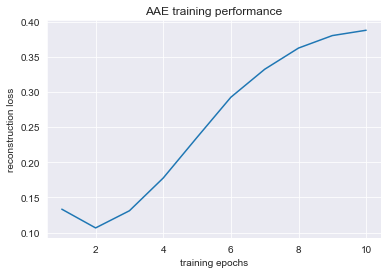

In [139]:
# plot the reconstruction loss per training epoch
plt.plot(range(1, len(epoch_reconstruction_losses)+1), epoch_reconstruction_losses)

# set plot title
plt.title('AAE training performance')

# set plot axis labels
plt.xlabel('training epochs')
plt.ylabel('reconstruction loss')

Let's now evaluate the magnitude of the distinct losses with progressing training:

Text(0, 0.5, 'reconstruction loss')

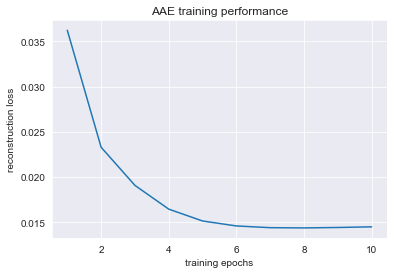

In [41]:
# plot the reconstruction loss per training epoch
plt.plot(range(1, len(epoch_reconstruction_losses)+1), epoch_reconstruction_losses)

# set plot title
plt.title('AAE training performance')

# set plot axis labels
plt.xlabel('training epochs')
plt.ylabel('reconstruction loss')

Text(0, 0.5, 'discrimination loss')

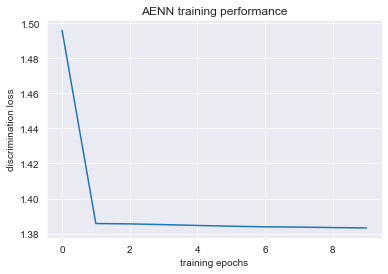

In [42]:
# plot the discriminator loss per training epoch
plt.plot(range(0, len(epoch_discriminator_losses)), epoch_discriminator_losses)

# set plot title
plt.title('AENN training performance')

# set plot axis labels
plt.xlabel('training epochs')
plt.ylabel('discrimination loss')

Text(0, 0.5, 'generation loss')

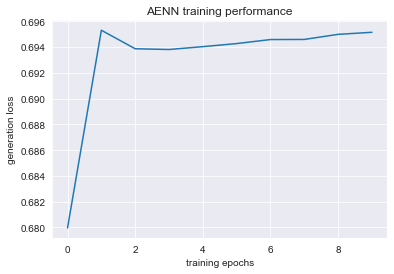

In [43]:
# plot the generator loss per training epoch
plt.plot(range(0, len(epoch_generator_losses)), epoch_generator_losses)

# set plot title
plt.title('AENN training performance')

# set plot axis labels
plt.xlabel('training epochs')
plt.ylabel('generation loss')